# Set up

In [20]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from sklearn import metrics
from scipy.stats import norm

from statsmodels.stats.contingency_tables import Table2x2
from palettable.colorbrewer.qualitative import Set1_5
from palettable.cartocolors.qualitative import Vivid_5
from tableone import TableOne


import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
from util.calc_util import calc_fisher
from ast import literal_eval


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
large_font = 20
medium_font = 15
small_font = 10 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Load Clinical Data and perform filtering + add PCs

In [22]:
integrated_df_path = "data/clin_df.tsv"
clinical_df = pd.read_csv(integrated_df_path,sep="\t")
clinical_df.head()


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ID,Age,Histology,CancerGrade,CancerStage_T,CancerStage_N,CancerStage_M,ER+,PR+,HER2+,...,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_PT_UKB_20200608,PRSWEB_PHECODE174.1_UKBB-SAIGE-HRC-X174.1_LASSOSUM_MGI_20200608,PRSWEB_PHECODE174.1_UKBB-SAIGE-HRC-X174.1_PT_MGI_20200608,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_LASSOSUM_UKB_20200608,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_PRS-CS_MGI_20200608,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_PRS-CS_UKB_20200608,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_PT_MGI_20200608,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_PT_UKB_20200608,PGS000004
0,BC_P_001,47.0,4-Invasive lobular carcinoma,2-Grade 2,2-T2,0-No,0-M0,True,True,False,...,-0.000060,0.000024,0.003521,7.820000e-07,5.620000e-06,-1.140000e-07,-5.560000e-08,0.000957,-0.002350,0.001704
1,BC_P_002,47.0,4-Invasive lobular carcinoma,2-Grade 2,3-T3,1-N1,0-M0,True,False,False,...,0.000800,0.000030,0.004716,2.650000e-06,9.620000e-06,7.690000e-08,6.060000e-08,0.002676,0.003009,0.001686
2,BC_P_003,44.0,3-Invasive ductal carcinoma,3-Grade 3,3-T3,0-No,0-M0,False,False,False,...,0.000548,0.000014,0.001436,3.570000e-07,-9.280000e-08,-6.660000e-08,-8.940000e-08,0.001812,0.000084,0.001325
3,BC_P_004,57.0,2-Lobular carcinoma in situ,2-Grade 2,1-T1c,0-No,0-M0,True,True,False,...,0.000868,0.000046,0.012965,1.600000e-05,2.240000e-05,5.210000e-08,5.630000e-08,0.003256,0.006383,0.002665
4,BC_P_005,47.0,3-Invasive ductal carcinoma,2-Grade 2,2-T2,0-No,0-M0,False,False,True,...,0.001066,0.000022,0.009197,4.840000e-06,1.160000e-05,-6.180000e-08,-6.680000e-08,0.004745,0.007003,0.002896


## Loading coverage info on lpWGS and WES

In [23]:
lpwgs_coverage_df = pd.read_csv("data/lpWGS_sample.tsv",sep="\t")
lpwgs_coverage_df["ID"] = ["_".join(name.split("-")[:3]) for name in lpwgs_coverage_df["entity:sample_id"]]
lpwgs_coverage_df_subset = lpwgs_coverage_df[lpwgs_coverage_df["ID"].isin(clinical_df["ID"])]

clinical_df_wes = clinical_df.copy()
lpwgs_coverage_df_subset.head()


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,entity:sample_id,hg38_sampleMeanCoverage,ID
0,BC-P-001-P1-B1_L_172936,1.29,BC_P_001
1,BC-P-002-P1-C1_L_172937,1.12,BC_P_002
2,BC-P-003-P1-D1_L_172938,1.18,BC_P_003
3,BC-P-004-P1-E1_L_172939,1.33,BC_P_004
4,BC-P-005-P1-F1_L_172940,1.40,BC_P_005


## Figure 2 (panel a&b)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/nanops.py:1723: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  return np.percentile(values, q, axis=1, interpolation=interpolation)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/nanops.py:1723: DeprecationWarning: the `interpolation=` argument to percentile was re

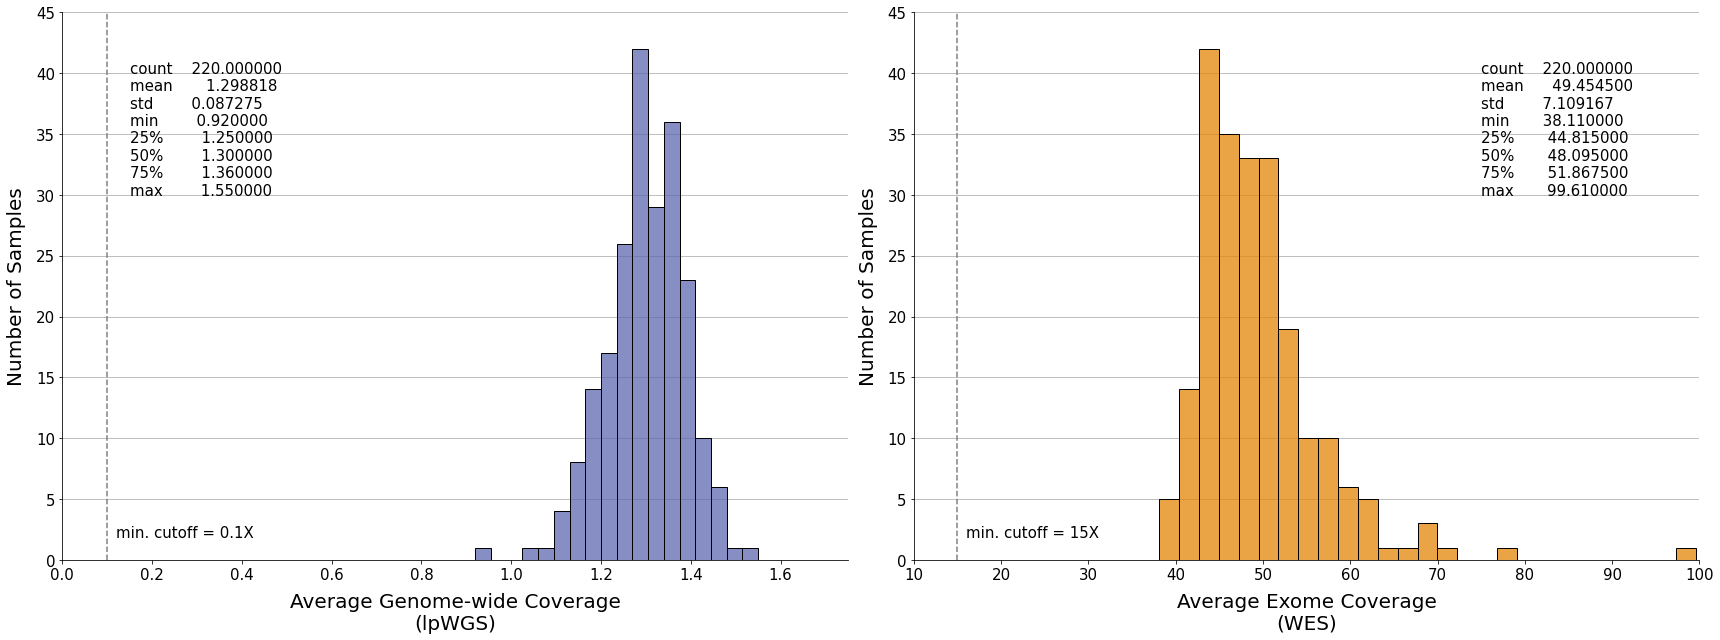

In [24]:


fig,axes = plt.subplots(figsize=(24,9),ncols=2)

## lpwgs
sns.histplot(data=lpwgs_coverage_df_subset,x="hg38_sampleMeanCoverage",ax=axes[0],color=Vivid_5.mpl_colors[1])
axes[0].set_axisbelow(True)
axes[0].grid(axis="y")

axes[0].spines.top.set_visible(False)
axes[0].spines.right.set_visible(False)

axes[0].tick_params(axis='both', which='major', labelsize=medium_font)
axes[0].set_xlabel("Average Genome-wide Coverage\n(lpWGS)",fontsize=large_font,labelpad=10)
axes[0].set_ylabel("Number of Samples",fontsize=large_font,labelpad=10)

axes[0].set_xlim((0,1.75))
axes[0].set_ylim((0,45))
axes[0].axvline(0.1,linestyle="--",color="gray")

display_str = "\n".join(str(lpwgs_coverage_df_subset["hg38_sampleMeanCoverage"].describe()).split("\n")[:-1])

axes[0].annotate(xy=(0.15,30),text=display_str,fontsize=medium_font)
axes[0].annotate(xy=(0.12,1.85),text="min. cutoff = 0.1X",fontsize=medium_font)

## WES
sns.histplot(data=clinical_df_wes,x="sampleMeanCoverage",ax=axes[1],color=Vivid_5.mpl_colors[0])
axes[1].set_axisbelow(True)
axes[1].grid(axis="y")

axes[1].spines.top.set_visible(False)
axes[1].spines.right.set_visible(False)

axes[1].tick_params(axis='both', which='major', labelsize=medium_font)
axes[1].set_xlabel("Average Exome Coverage\n(WES)",fontsize=large_font,labelpad=10)
axes[1].set_ylabel("Number of Samples",fontsize=large_font,labelpad=10)

axes[1].set_xlim((10,100))
axes[1].set_ylim((0,45))
axes[1].axvline(15,linestyle="--",color="gray")

display_str = "\n".join(str(clinical_df_wes["sampleMeanCoverage"].describe()).split("\n")[:-1])

axes[1].annotate(xy=(75,30),text=display_str,fontsize=medium_font)
axes[1].annotate(xy=(16,1.85),text="min. cutoff = 15X",fontsize=medium_font)

plt.tight_layout()
plt.savefig("figures/fig_2_coverage_plot.png",dpi=300)
plt.savefig("figures/fig_2_coverage_plot.eps",dpi=300)



## Figure 2 (Panel c&d)

In [25]:
# Add PC information
pc_df = pd.read_csv("data/ancestry_pcs.tsv",sep="\t")
scores = [literal_eval(score) for score in pc_df["scores"]]
pc_components_df = pd.DataFrame(data=scores,columns=[f"PC_{i}" for i in range(1,101)])

# Keep only first 10 PCs
pc_components_df = pc_components_df.iloc[:,:10]
pc_components_df.insert(0,"ID",pc_df["s"].apply(lambda x: "_".join(x.split("-")[:3])))
clinical_df = clinical_df.merge(pc_components_df,left_on="ID",right_on="ID",how="left")

ancestry_df = pd.read_csv("data/ancestry_assignments.tsv",sep="\t")
pc_components_df_with_ancestry = ancestry_df.merge(pc_components_df,on="ID")
pc_components_df_with_ancestry = pc_components_df_with_ancestry.replace({"Middle Eastern":"MID (This Cohort)"})
pc_components_df_with_ancestry.head()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ID,Population_Code,Super_Population,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10
0,BC_P_001,MID (This Cohort),MID (This Cohort),-0.017264,-0.018577,0.038931,0.014054,0.005960,-0.016127,0.006660,0.018212,-0.004800,-0.007986
1,BC_P_002,MID (This Cohort),MID (This Cohort),0.008336,-0.015309,0.046967,0.025561,0.003875,-0.007231,0.009379,0.012910,0.008274,0.003415
2,BC_P_003,MID (This Cohort),MID (This Cohort),-0.001888,-0.010207,0.042040,0.008720,0.003740,-0.015715,0.008654,0.008089,0.000078,0.006885
3,BC_P_004,MID (This Cohort),MID (This Cohort),-0.020342,-0.014841,0.029483,0.005976,0.005031,-0.009841,0.005231,0.007291,-0.001679,-0.001122
4,BC_P_005,MID (This Cohort),MID (This Cohort),-0.017141,-0.024921,0.032897,0.007751,0.003208,0.000312,0.005803,0.004934,0.000394,0.004869


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/utils.py:387: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/utils.py:387: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles


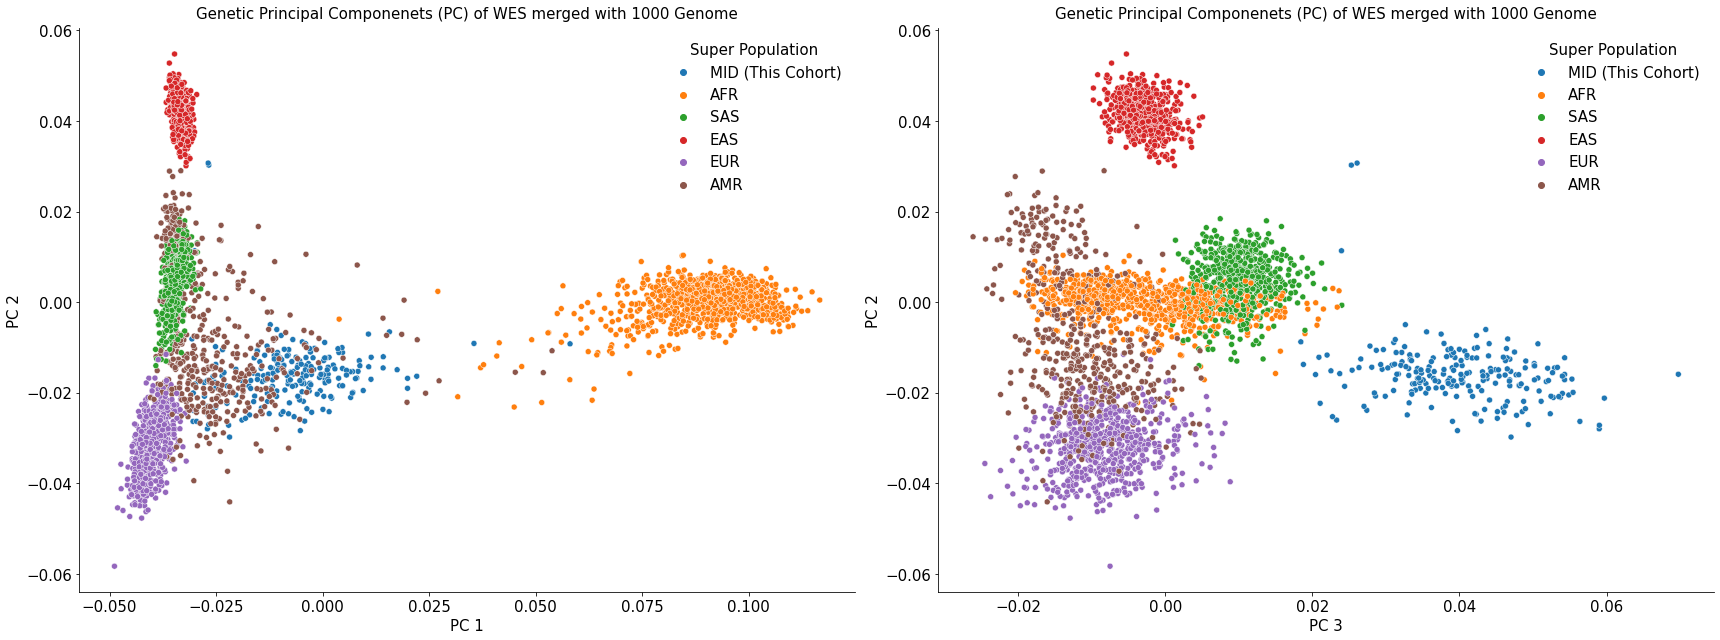

In [26]:
fig,axes = plt.subplots(figsize=(24,9),ncols=2)

sns.scatterplot(
    data=pc_components_df_with_ancestry,
    x="PC_1",
    y="PC_2",
    hue="Super_Population",
    ax=axes[0]
)

sns.despine(ax=axes[0])
sns.move_legend(axes[0],loc="upper right",frameon=False,title="Super Population",fontsize=medium_font,title_fontsize=medium_font)
axes[0].set_xlabel("PC 1",fontsize=medium_font)
axes[0].set_ylabel("PC 2",fontsize=medium_font)

sns.scatterplot(
    data=pc_components_df_with_ancestry,
    x="PC_3",
    y="PC_2",
    hue="Super_Population",
    ax=axes[1]
)

sns.despine(ax=axes[1])
sns.move_legend(axes[1],loc="upper right",frameon=False,title="Super Population",fontsize=medium_font,title_fontsize=medium_font)
axes[1].set_xlabel("PC 3",fontsize=medium_font)
axes[1].set_ylabel("PC 2",fontsize=medium_font)

axes[0].set_title("Genetic Principal Componenets (PC) of WES merged with 1000 Genome",pad=10,size=medium_font)
axes[1].set_title("Genetic Principal Componenets (PC) of WES merged with 1000 Genome",pad=10,size=medium_font)

axes[0].tick_params(axis='both', which='major', labelsize=medium_font)
axes[1].tick_params(axis='both', which='major', labelsize=medium_font)

plt.tight_layout()
plt.savefig("figures/fig_2_pc_plot.png",dpi=300)
plt.savefig("figures/fig_2_pc_plot.eps",dpi=300)




# Figure 3 (See Plot Exome Dosage Notebook)

# Figure 4 (PRS AUC correlation)

In [ ]:
## Remove individuals with unreported family history of breast cancer or are related for downstream analysus
clinical_df_filtered = clinical_df[clinical_df['RelatednessQC_Removed']==False].copy()
clinical_df_filtered = clinical_df_filtered.dropna(subset=["AnyDegreeBC"])
clinical_df_filtered


## Panel A)

### Load PRS related information

In [27]:
ukb_prs_info = pd.read_csv("./data/CancerPRSWeb/174.1_UKB_1.txt",sep="\t")
mgi_prs_info = pd.read_csv("./data/CancerPRSWeb/174.1_MGI_1.txt",sep="\t")
combined_prs_info = pd.concat([ukb_prs_info,mgi_prs_info],ignore_index=True)
combined_prs_info.columns = [col.strip() for col in combined_prs_info.columns]
combined_prs_info_subset = combined_prs_info[['Prswebprefix','# SNPS','AUC Estimate','.Method']]

# Add info on the 313 SNP (PGS000004) PRS
# Performance Metrics and Method retrieved from: https://www.pgscatalog.org/score/PGS000004/
# Performance Metrics ID: PPM000004

combined_prs_info_subset = combined_prs_info_subset.append({
    "Prswebprefix": "PGS000004",
    "# SNPS": 313,
    "AUC Estimate": 0.63,
    ".Method": "Hard-Thresholding"
},ignore_index=True)

combined_prs_info_subset.head()


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Prswebprefix,# SNPS,AUC Estimate,.Method
0,PRSWEB_PHECODE174.1_GWAS-Catalog-r2019-05-03-X...,64,0.596,P_5e-09
1,PRSWEB_PHECODE174.1_GWAS-Catalog-r2019-05-03-X...,86,0.593,P_5e-08
2,PRSWEB_PHECODE174.1_GWAS-Catalog-r2019-05-03-X...,93,0.595,P_5e-07
3,PRSWEB_PHECODE174.1_GWAS-Catalog-r2019-05-03-X...,102,0.591,P_5e-06
4,PRSWEB_PHECODE174.1_GWAS-Catalog-r2019-05-03-X...,105,0.588,P_5e-05


### Residualize every PRS


In [28]:
pc_cols = [f"PC_{i}" for i in range(1,11)]
prs_web_cols = [col for col in clinical_df_filtered.columns if (("PRSWEB" in col) or ("PGS" in col)) and "residual" not in col]

for idx in range(len(prs_web_cols)):
    cur_prs_name = prs_web_cols[idx]
    X_pc_only = np.array(clinical_df_filtered[pc_cols],dtype=float)
    X_pc_only = sm.add_constant(X_pc_only)
    ols_model_res_prs = sm.OLS(clinical_df_filtered[cur_prs_name].to_numpy(), X_pc_only).fit(maxiter=100).resid

    clinical_df_filtered[f"{cur_prs_name}_residual"] = ols_model_res_prs
clinical_df_filtered


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ID,Age,Histology,CancerGrade,CancerStage_T,CancerStage_N,CancerStage_M,ER+,PR+,HER2+,...,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_PRS-CS_MGI_20200608_residual,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_PRS-CS_UKB_20200608_residual,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_PT_MGI_20200608_residual,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_PT_UKB_20200608_residual,PGS000004_residual,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608_raw,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608_raw_standardized,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608_residual_standardized,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608_raw_residual,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608_raw_standardized_residual
0,BC_P_001,47.0,4-Invasive lobular carcinoma,2-Grade 2,2-T2,0-No,0-M0,True,True,False,...,-8.827125e-08,-6.180875e-08,-0.001643,-0.006295,-0.000435,4.800000e-07,-1.071499,-0.777759,-1.165669e-06,-0.737352
1,BC_P_002,47.0,4-Invasive lobular carcinoma,2-Grade 2,3-T3,1-N1,0-M0,True,False,False,...,9.906111e-08,5.310167e-08,0.000664,0.002214,0.000437,2.840000e-06,0.421336,0.442861,6.637397e-07,0.419853
2,BC_P_003,44.0,3-Invasive ductal carcinoma,3-Grade 3,3-T3,0-No,0-M0,False,False,False,...,-6.093287e-08,-1.241809e-07,-0.000575,-0.001447,-0.000289,8.440000e-07,-0.841249,-1.190310,-1.783982e-06,-1.128471
3,BC_P_004,57.0,2-Lobular carcinoma in situ,2-Grade 2,1-T1c,0-No,0-M0,True,True,False,...,7.003773e-08,3.662484e-08,0.000183,0.003230,0.000466,3.680000e-06,0.952684,1.092739,1.637747e-06,1.035969
4,BC_P_005,47.0,3-Invasive ductal carcinoma,2-Grade 2,2-T2,0-No,0-M0,False,False,True,...,-4.103003e-08,-8.876075e-08,0.001396,0.004129,0.000656,1.960000e-06,-0.135315,-0.137074,-2.054409e-07,-0.129953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,BC_P_231,51.0,12- Other,2-Grade 2,1-T1c,0-No,0-M0,True,True,False,...,4.051051e-09,-4.419472e-08,0.001983,0.003564,0.001516,3.580000e-06,0.889428,0.180187,2.700567e-07,0.170826
211,BC_P_232,61.0,1-Ductal carcinoma in situ,2-Grade 2,1-T1c,0-No,0-M0,True,True,False,...,1.696987e-08,1.402040e-08,0.001512,0.000774,0.002464,3.040000e-06,0.547847,0.395077,5.921236e-07,0.374552
212,BC_P_233,49.0,3-Invasive ductal carcinoma,3-Grade 3,1-T1c,1-N1,0-M0,True,True,False,...,-1.156117e-08,-2.673160e-09,0.000003,-0.002358,-0.000876,1.530000e-06,-0.407314,-0.353830,-5.303044e-07,-0.335448
215,BC_P_236,64.0,2-Lobular carcinoma in situ,2-Grade 2,1-T1c,0-No,0-M0,True,True,NaN,...,-5.687064e-09,2.747332e-08,0.001612,0.003057,0.000508,1.280000e-06,-0.565454,-0.875538,-1.312216e-06,-0.830052


### Get performance of each set of PRS (alone + residualized against top 10 PCs)

In [29]:
pc_cols = [f"PC_{i}" for i in range(1,11)]

df_to_eval = clinical_df_filtered[clinical_df_filtered["FirstDegreeBC"].notna()]

prs_web_cols = [col for col in clinical_df_filtered.columns if (("PRSWEB" in col) or ("PGS" in col)) and "residual" not in col]
prs_web_first_bc_aurocs = [roc_auc_score(df_to_eval["FirstDegreeBC"]==True, df_to_eval[col]) for col in prs_web_cols]
prs_web_any_bc_aurocs = [roc_auc_score(df_to_eval["AnyDegreeBC"]==True, df_to_eval[col]) for col in prs_web_cols]

residualzed_prs = {}

rows = []

def get_prs_performance(df,prs_col,outcome_col):
    y = np.array(df[outcome_col],dtype=float) == True
    return roc_auc_score(y, df[prs_col])
    

for idx in range(len(prs_web_cols)):
    cur_prs_name = prs_web_cols[idx]
    cur_prs_resid_name = f"{cur_prs_name}_residual"
    
    # Overall PRS performance
    auroc_first_prs_only = get_prs_performance(df_to_eval,cur_prs_name,"FirstDegreeBC")
    auroc_first_prs_res_only = get_prs_performance(df_to_eval,cur_prs_resid_name,"FirstDegreeBC")
    auroc_any_prs_only = get_prs_performance(df_to_eval,cur_prs_name,"AnyDegreeBC")
    auroc_any_prs_res_only = get_prs_performance(df_to_eval,cur_prs_resid_name,"AnyDegreeBC")
        
    ## ER+ or PR+ Only
    df_to_eval_er_or_pr_subset = df_to_eval[(df_to_eval["ER+"]==True)|(df_to_eval["PR+"]==True)].copy()
    auroc_first_prs_only_er_or_pr_subset = get_prs_performance(df_to_eval_er_or_pr_subset,cur_prs_name,"FirstDegreeBC")
    auroc_first_prs_res_only_er_or_pr_subset = get_prs_performance(df_to_eval_er_or_pr_subset,cur_prs_resid_name,"FirstDegreeBC")
    auroc_any_prs_only_er_or_pr_subset = get_prs_performance(df_to_eval_er_or_pr_subset,cur_prs_name,"AnyDegreeBC")
    auroc_any_prs_res_only_er_or_pr_subset = get_prs_performance(df_to_eval_er_or_pr_subset,cur_prs_resid_name,"AnyDegreeBC")
        
    ## HER2+ Only
    df_to_eval_her2_subset = df_to_eval[df_to_eval["HER2+"]==True].copy()
    auroc_first_prs_only_her2_subset = get_prs_performance(df_to_eval_her2_subset,cur_prs_name,"FirstDegreeBC")
    auroc_first_prs_res_only_her2_subset = get_prs_performance(df_to_eval_her2_subset,cur_prs_resid_name,"FirstDegreeBC")
    auroc_any_prs_only_her2_subset = get_prs_performance(df_to_eval_her2_subset,cur_prs_name,"AnyDegreeBC")
    auroc_any_prs_res_only_her2_subset = get_prs_performance(df_to_eval_her2_subset,cur_prs_resid_name,"AnyDegreeBC")
    
    ## TNBC Only
    df_to_eval_tnbc_subset = df_to_eval[
        (df_to_eval["ER+"]==False)&(df_to_eval["PR+"]==False)&(df_to_eval["HER2+"]==False)
    ].copy()
    auroc_first_prs_only_tnbc_subset = get_prs_performance(df_to_eval_tnbc_subset,cur_prs_name,"FirstDegreeBC")
    auroc_first_prs_res_only_tnbc_subset = get_prs_performance(df_to_eval_tnbc_subset,cur_prs_resid_name,"FirstDegreeBC")
    auroc_any_prs_only_tnbc_subset = get_prs_performance(df_to_eval_tnbc_subset,cur_prs_name,"AnyDegreeBC")
    auroc_any_prs_res_only_tnbc_subset = get_prs_performance(df_to_eval_tnbc_subset,cur_prs_resid_name,"AnyDegreeBC")
    
    rows.append({
        "prs_name":cur_prs_name,
        
        "total_obs":len(df_to_eval),
        "total_obs_first":df_to_eval["FirstDegreeBC"].sum(),
        "total_obs_any":df_to_eval["AnyDegreeBC"].sum(),
        "prs_first_fam_auroc_prs_only":auroc_first_prs_only,
        "prs_resid_first_fam_auroc":auroc_first_prs_res_only,
        "prs_any_fam_auroc_prs_only":auroc_any_prs_only,
        "prs_resid_any_fam_auroc":auroc_any_prs_res_only,
        
        "total_obs_er_or_pr_subset":len(df_to_eval_er_or_pr_subset),
        "total_obs_er_or_pr_subset_first":df_to_eval_er_or_pr_subset["FirstDegreeBC"].sum(),
        "total_obs_er_or_pr_subset_any":df_to_eval_er_or_pr_subset["AnyDegreeBC"].sum(),
        "prs_first_fam_auroc_prs_only_er_or_pr_subset":auroc_first_prs_only_er_or_pr_subset,
        "prs_resid_first_fam_auroc_er_or_pr_subset":auroc_first_prs_res_only_er_or_pr_subset,
        "prs_any_fam_auroc_prs_only_er_or_pr_subset":auroc_any_prs_only_er_or_pr_subset,
        "prs_resid_any_fam_auroc_er_or_pr_subset":auroc_any_prs_res_only_er_or_pr_subset,
        
        "total_obs_her2_subset": len(df_to_eval_her2_subset),
        "total_obs_her2_subset_first":df_to_eval_her2_subset["FirstDegreeBC"].sum(),
        "total_obs_her2_subset_any":df_to_eval_her2_subset["AnyDegreeBC"].sum(),
        "prs_first_fam_auroc_prs_only_her2_subset":auroc_first_prs_only_her2_subset,
        "prs_resid_first_fam_auroc_her2_subset":auroc_first_prs_res_only_her2_subset,
        "prs_any_fam_auroc_prs_only_her2_subset":auroc_any_prs_only_her2_subset,
        "prs_resid_any_fam_auroc_her2_subset":auroc_any_prs_res_only_her2_subset,
        
        "total_obs_tnbc_subset": len(df_to_eval_tnbc_subset),
        "total_obs_tnbc_subset_first":df_to_eval_tnbc_subset["FirstDegreeBC"].sum(),
        "total_obs_tnbc_subset_any":df_to_eval_tnbc_subset["AnyDegreeBC"].sum(),
        "prs_first_fam_auroc_prs_only_tnbc_subset":auroc_first_prs_only_tnbc_subset,
        "prs_resid_first_fam_auroc_tnbc_subset":auroc_first_prs_res_only_tnbc_subset,
        "prs_any_fam_auroc_prs_only_tnbc_subset":auroc_any_prs_only_tnbc_subset,
        "prs_resid_any_fam_auroc_tnbc_subset":auroc_any_prs_res_only_tnbc_subset,
    })
        

prs_web_fam_df = pd.DataFrame(data=rows)
prs_web_fam_df.loc[prs_web_fam_df["prs_name"].str.contains("_MGI"),"DB"] = "MGI"
prs_web_fam_df.loc[prs_web_fam_df["DB"].isna(),"DB"] = "UKB"

prs_web_fam_df_merged = prs_web_fam_df.merge(combined_prs_info_subset,left_on="prs_name",right_on="Prswebprefix",how="left").sort_values(by="prs_resid_any_fam_auroc",ascending=False).reset_index(drop=True)
prs_web_fam_df_merged






/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,prs_name,total_obs,total_obs_first,total_obs_any,prs_first_fam_auroc_prs_only,prs_resid_first_fam_auroc,prs_any_fam_auroc_prs_only,prs_resid_any_fam_auroc,total_obs_er_or_pr_subset,total_obs_er_or_pr_subset_first,...,total_obs_tnbc_subset_any,prs_first_fam_auroc_prs_only_tnbc_subset,prs_resid_first_fam_auroc_tnbc_subset,prs_any_fam_auroc_prs_only_tnbc_subset,prs_resid_any_fam_auroc_tnbc_subset,DB,Prswebprefix,# SNPS,AUC Estimate,.Method
0,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LA...,200,25,53,0.649371,0.662629,0.596072,0.604800,117,13,...,7,1.0000,1.0000,0.642857,0.657143,MGI,NaN,NaN,NaN,NaN
1,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LA...,200,25,53,0.649371,0.662629,0.596072,0.604800,117,13,...,7,1.0000,1.0000,0.642857,0.657143,MGI,NaN,NaN,NaN,NaN
2,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LA...,200,25,53,0.649371,0.662629,0.596072,0.604800,117,13,...,7,1.0000,1.0000,0.642857,0.657143,MGI,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LA...,118388.0,0.639,Lassosum
3,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LA...,200,25,53,0.655771,0.661943,0.587088,0.586831,117,13,...,7,1.0000,1.0000,0.700000,0.671429,UKB,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LA...,286144.0,0.643,Lassosum
4,PRSWEB_PHECODE174.1_UKBB-SAIGE-HRC-X174.1_LASS...,200,25,53,0.666171,0.656000,0.581954,0.579772,117,13,...,7,1.0000,1.0000,0.571429,0.600000,MGI,PRSWEB_PHECODE174.1_UKBB-SAIGE-HRC-X174.1_LASS...,6977.0,0.611,Lassosum
5,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_PRS-CS_...,200,25,53,0.625029,0.641829,0.551405,0.563214,117,13,...,7,1.0000,1.0000,0.457143,0.514286,UKB,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_PRS-CS_...,1116546.0,0.623,PRS-CS
6,PRSWEB_PHECODE174.1_GWAS-Catalog-r2019-05-03-X...,200,25,53,0.573486,0.572571,0.556283,0.553074,117,13,...,7,0.6875,0.5000,0.514286,0.471429,UKB,PRSWEB_PHECODE174.1_GWAS-Catalog-r2019-05-03-X...,79.0,0.599,P&T
7,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_PT...,200,25,53,0.566857,0.579657,0.551149,0.551277,117,13,...,7,1.0000,1.0000,0.714286,0.671429,UKB,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_PT...,1682.0,0.631,P&T
8,PRSWEB_PHECODE174.1_GWAS-Catalog-r2019-05-03-X...,200,25,53,0.558400,0.549943,0.562315,0.551020,117,13,...,7,0.9375,0.8750,0.757143,0.757143,UKB,PRSWEB_PHECODE174.1_GWAS-Catalog-r2019-05-03-X...,105.0,0.588,P_5e-05
9,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_PT...,200,25,53,0.593029,0.601829,0.551983,0.550635,117,13,...,7,1.0000,1.0000,0.685714,0.671429,MGI,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_PT...,3038.0,0.635,P&T


In [30]:
prs_web_fam_df_merged.to_csv("./data/outputs/prs_performances.tsv",sep="\t",index=False)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


###  Plotting

In [31]:
prs_web_fam_df_merged = pd.read_csv("./data/outputs/prs_performances.tsv",sep="\t")
prs_web_fam_df_merged = prs_web_fam_df_merged.rename(columns={".Method":"Method"})
prs_web_fam_df_merged = prs_web_fam_df_merged.replace({"P_5e-05":r"GWAS Catalog ($p<5\times10^{-5}$)"})
prs_web_fam_df_merged = prs_web_fam_df_merged.replace({"Hard-Thresholding":r"313-SNP"})



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
def joint_plot_with_pval(df,col_x,col_y):
    graph = sns.jointplot(data=df,x=col_x, y=col_y, kind="reg")
    x = df[col_x].to_numpy()
    y = df[col_y].to_numpy()
    nas = np.logical_or(np.isnan(x), np.isnan(y))
    r, p = stats.spearmanr(x[~nas],y[~nas])
    # if you choose to write your own legend, then you should adjust the properties then
    phantom, = graph.ax_joint.plot([], [], linestyle="", alpha=0)
    # here graph is not a ax but a joint grid, so we access the axis through ax_joint method
    graph.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/utils.py:387: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


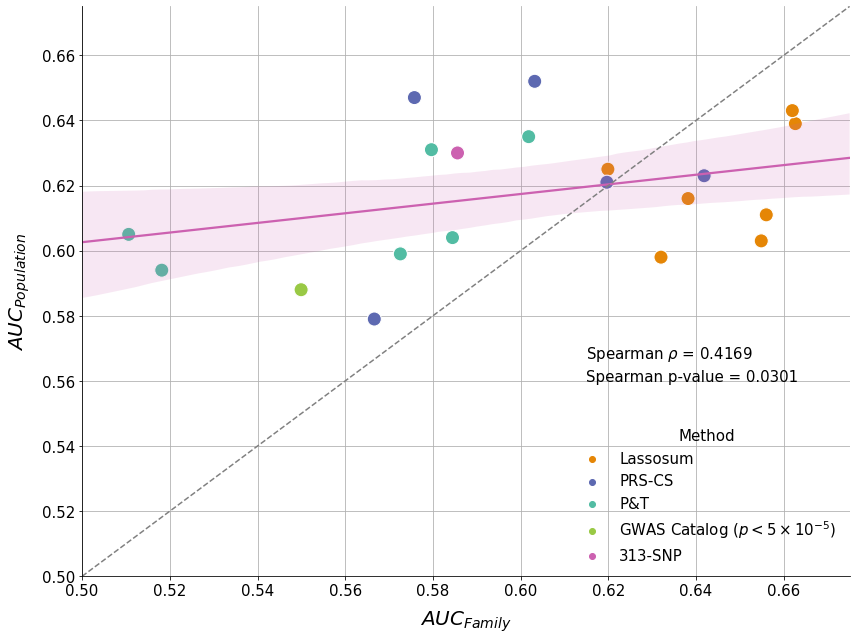

In [33]:
from palettable.colorbrewer.qualitative import Set1_5
from palettable.cartocolors.qualitative import Vivid_6

prs_method_color_palette = {
    "Lassosum": Vivid_5.mpl_colors[0],
    "PRS-CS": Vivid_5.mpl_colors[1],
    "P&T": Vivid_5.mpl_colors[2],
    r"GWAS Catalog ($p<5\times10^{-5}$)": Vivid_5.mpl_colors[3],
    r"313-SNP": Vivid_5.mpl_colors[4],
}

def plot_fam_to_pop(
    df,
    x,
    y,
    xlim=(0.5,0.675),
    ylim=(0.5,0.675),
    xlabel="$AUC_{Family}$",
    ylabel="$AUC_{Population}$"
):
    fig,ax = plt.subplots(figsize=(12,9))

    col_x = x #"prs_resid_first_fam_auroc"
    col_y = y #"AUC Estimate"

    sns.scatterplot(
        data=df,
        x=col_x,
        y=col_y,
        hue="Method",
        ax=ax,
        s=200,
        palette=prs_method_color_palette
    )

    ax.set_axisbelow(True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    sns.regplot(
        data=df,
        x=col_x,
        y=col_y,
        marker='',
        line_kws={"color":Vivid_5.mpl_colors[4]},
        ax=ax,
        truncate=False
    )

    ax.plot([0, 1], [0, 1], transform=ax.transAxes,linestyle="--",color="gray")

    sns.move_legend(ax,"lower right",frameon=False,fontsize=medium_font,title_fontsize=medium_font)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_xlabel(xlabel,size=large_font,labelpad=10)
    ax.set_ylabel(ylabel,size=large_font,labelpad=10)
    ax.grid(axis="x")
    ax.grid(axis="y")

    ax.tick_params(axis='both', which='major', labelsize=medium_font)

    x = df[col_x].to_numpy()
    y = df[col_y].to_numpy()
    nas = np.logical_or(np.isnan(x), np.isnan(y))
    r, p = stats.spearmanr(x[~nas],y[~nas],alternative="greater")


    ax.annotate(r"Spearman p-value = "+ f"{round(p,4)}",(0.615,0.56),size=medium_font)
    ax.annotate(r"Spearman $\rho$ = "+ f"{round(r,4)}",(0.615,0.567),size=medium_font)

plot_fam_to_pop(df=prs_web_fam_df_merged,x="prs_resid_first_fam_auroc",y="AUC Estimate")

plt.tight_layout()
plt.savefig("figures/fig_4_prs_auc_correlations.png",dpi=300)#,bbox_layout="tight")
plt.savefig("figures/fig_4_prs_auc_correlations.eps",dpi=300)#,bbox_layout="tight")



### Select the most performant PRS
To perform the same analysis using other PRS, change "prs_to_use" to the name of the desire PRS

In [34]:
prs_to_use = prs_web_fam_df_merged.sort_values(by="prs_resid_first_fam_auroc",ascending=False)["prs_name"][0]
#prs_to_use = "PGS000004"
prs_to_use


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608_raw_standardized'

In [35]:
prs_to_use_raw = f"{prs_to_use}_raw"
prs_to_use_raw_std = f"{prs_to_use}_raw_standardized"
prs_to_use_adjusted = f"{prs_to_use}_residual"
prs_to_use_adjusted_std = f"{prs_to_use}_residual_standardized"

def standardize_prs(df,col):
    return (df[col] - df[col].mean())/df[col].std()

clinical_df_filtered[prs_to_use_raw] = clinical_df_filtered[prs_to_use]
clinical_df_filtered[prs_to_use_raw_std] = standardize_prs(clinical_df_filtered,prs_to_use_raw)
clinical_df_filtered[prs_to_use_adjusted] = clinical_df_filtered[prs_to_use_adjusted]
clinical_df_filtered[prs_to_use_adjusted_std] = standardize_prs(clinical_df_filtered,prs_to_use_adjusted)
clinical_df_filtered

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ID,Age,Histology,CancerGrade,CancerStage_T,CancerStage_N,CancerStage_M,ER+,PR+,HER2+,...,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_PT_UKB_20200608_residual,PGS000004_residual,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608_raw,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608_raw_standardized,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608_residual_standardized,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608_raw_residual,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608_raw_standardized_residual,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608_raw_standardized_raw,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608_raw_standardized_raw_standardized,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608_raw_standardized_residual_standardized
0,BC_P_001,47.0,4-Invasive lobular carcinoma,2-Grade 2,2-T2,0-No,0-M0,True,True,False,...,-0.006295,-0.000435,4.800000e-07,-1.071499,-0.777759,-1.165669e-06,-0.737352,-1.071499,-1.071499,-0.777759
1,BC_P_002,47.0,4-Invasive lobular carcinoma,2-Grade 2,3-T3,1-N1,0-M0,True,False,False,...,0.002214,0.000437,2.840000e-06,0.421336,0.442861,6.637397e-07,0.419853,0.421336,0.421336,0.442861
2,BC_P_003,44.0,3-Invasive ductal carcinoma,3-Grade 3,3-T3,0-No,0-M0,False,False,False,...,-0.001447,-0.000289,8.440000e-07,-0.841249,-1.190310,-1.783982e-06,-1.128471,-0.841249,-0.841249,-1.190310
3,BC_P_004,57.0,2-Lobular carcinoma in situ,2-Grade 2,1-T1c,0-No,0-M0,True,True,False,...,0.003230,0.000466,3.680000e-06,0.952684,1.092739,1.637747e-06,1.035969,0.952684,0.952684,1.092739
4,BC_P_005,47.0,3-Invasive ductal carcinoma,2-Grade 2,2-T2,0-No,0-M0,False,False,True,...,0.004129,0.000656,1.960000e-06,-0.135315,-0.137074,-2.054409e-07,-0.129953,-0.135315,-0.135315,-0.137074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,BC_P_231,51.0,12- Other,2-Grade 2,1-T1c,0-No,0-M0,True,True,False,...,0.003564,0.001516,3.580000e-06,0.889428,0.180187,2.700567e-07,0.170826,0.889428,0.889428,0.180187
211,BC_P_232,61.0,1-Ductal carcinoma in situ,2-Grade 2,1-T1c,0-No,0-M0,True,True,False,...,0.000774,0.002464,3.040000e-06,0.547847,0.395077,5.921236e-07,0.374552,0.547847,0.547847,0.395077
212,BC_P_233,49.0,3-Invasive ductal carcinoma,3-Grade 3,1-T1c,1-N1,0-M0,True,True,False,...,-0.002358,-0.000876,1.530000e-06,-0.407314,-0.353830,-5.303044e-07,-0.335448,-0.407314,-0.407314,-0.353830
215,BC_P_236,64.0,2-Lobular carcinoma in situ,2-Grade 2,1-T1c,0-No,0-M0,True,True,NaN,...,0.003057,0.000508,1.280000e-06,-0.565454,-0.875538,-1.312216e-06,-0.830052,-0.565454,-0.565454,-0.875538


## Panel C)

In [36]:
def calc_auc_conf(auc,num_case,num_control,ci=0.95):
    alpha = 1-ci
    z_score = norm.ppf(1-(alpha/2))
    q_0 = auc*(1-auc)
    q_1 = (auc/(2-auc))-auc**2
    q_2 = ((2*(auc**2))/(1+auc)) - auc**2
    std_err = np.sqrt((q_0+(num_case-1)*q_1+(num_control-1)*q_2)/(num_case*num_control))
    upper = auc+z_score*std_err
    lower = auc-z_score*std_err
    return auc,lower,upper


def plot_multi_roc(
    df,
    labels_to_plot,
    pred_col,
    add_trivial=True,
    label_names=None,
    truth_labels=None,
    return_ranking=False,
    adjust_cols=None,
    legend_bbox=(0.55, 0.35),
    figsize=(12,9),
    label_colors=[],
    linewidth=2
):
    fig, ax = plt.subplots(figsize=figsize)
    for idx,label in enumerate(labels_to_plot):
        notna_df = df[df[label].notna()].copy()
        if truth_labels:
            truth = (notna_df[label] == truth_labels[idx]).astype(int).to_numpy()
        else:
            truth = notna_df[label].astype(int).to_numpy()
        num_case = np.sum(truth)
        num_control = len(notna_df)-num_case

        
        if adjust_cols:
            all_pred_cols = adjust_cols + [pred_col] if pred_col else adjust_cols
            X_adjusted = np.array(notna_df[all_pred_cols],dtype=float)
            X_adjusted = sm.add_constant(X_adjusted)
            y1 = truth
            
            X_adjusted_model = sm.GLM(y1, X_adjusted).fit(maxiter=100,family=sm.families.Binomial())
            pred = X_adjusted_model.predict(X_adjusted)   
        else:
            pred = notna_df[pred_col].to_numpy()

        fpr, tpr, thresh = metrics.roc_curve(truth, pred)
        auc = metrics.roc_auc_score(truth, pred)
        _,auc_lower,auc_upper = calc_auc_conf(auc,num_case,num_control)

        if label_names:
            label = label_names[idx]
        ax.plot(fpr,tpr,label=f"{label} (n={num_case}/{len(notna_df)}),\nAUC={auc:.3f} (95% CI: {auc_lower:.3f}-{auc_upper:.3f})",color=label_colors[idx],linewidth=linewidth)
    if add_trivial:
        ax.plot([0,1],[0,1],label=f"Trivial, AUC=0.5",linestyle="dashed",color="gray",linewidth=linewidth)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(axis="x")
    ax.grid(axis="y")
    ax.set_axisbelow(True)
    ax.legend(bbox_to_anchor=legend_bbox, ncol=1,frameon=False)
    
    return ax
    


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
from palettable.colorbrewer.qualitative import Paired_8
from palettable.colorbrewer.qualitative import Paired_10



labels_to_plot = [
    "FirstDegreeBC",
    "AnyDegreeBC",
    "FamilyCancer_FirstDegree",
    "FamilyCancer_AnyDegree",
]
truth_labels = [
    True,
    True,
    True,
    True,
]
label_names = [
    "BC in 1st-degree relative",
    "BC in any-degree relative",
    "Any Cancer in 1st-degree relative",
    "Any Cancer in any-degree relative",
]

label_colors = [
    Paired_10.mpl_colors[9],
    Paired_10.mpl_colors[8],
    Paired_10.mpl_colors[5],
    Paired_10.mpl_colors[4]
]
fam_hist_label_palette = {
    "BC in 1st-degree relative":"#e31b1b",
    "BC in any-degree relative":"#fc9a98",
    "Any Cancer in 1st-degree relative":"#ff7f00",
    "Any Cancer in any-degree relative":"#febe6e"
}


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/utils.py:387: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles


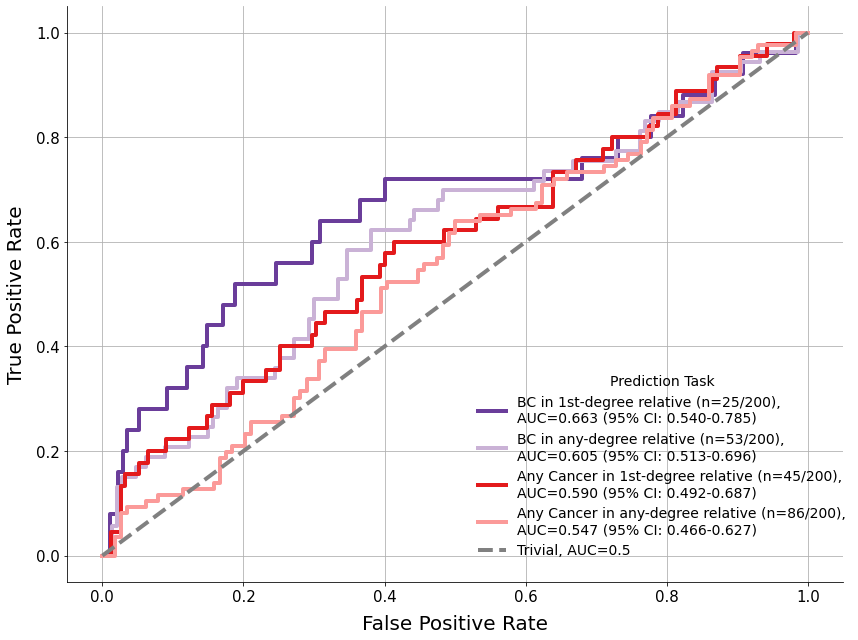

In [38]:
pred_col = prs_to_use_adjusted

ax = plot_multi_roc(
    clinical_df_filtered,
    labels_to_plot,
    pred_col,
    label_names=label_names,
    truth_labels=truth_labels,
    label_colors=label_colors,
    linewidth=4
)


ax.tick_params(axis='both', which='major', labelsize=medium_font)

sns.move_legend(ax,loc="lower right",bbox_to_anchor=(1.02, 0.02),frameon=False,title="Prediction Task",fontsize=14,title_fontsize=14)

ax.set_xlabel("False Positive Rate",size=large_font,labelpad=10)
ax.set_ylabel("True Positive Rate",size=large_font,labelpad=10)
# ax.set_title("PRS Performance in Predicting Family Cancer History",size=large_font,pad=10)

plt.tight_layout()
plt.savefig("figures/fig_4_prs_tasks_auc.png",dpi=300)#,bbox_layout="tight")
plt.savefig("figures/fig_4_prs_tasks_auc.eps",dpi=300)#,bbox_layout="tight")






### Supplemental Figure 1
 Negative Control Showing age is not predictive of Family Breast Cancer History


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/utils.py:387: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles


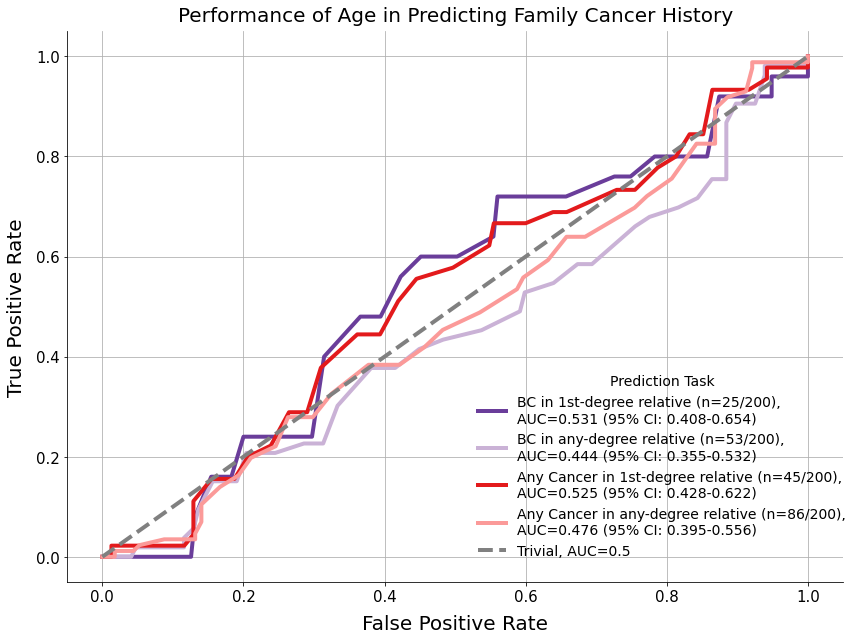

In [39]:

ax = plot_multi_roc(
    clinical_df_filtered,
    labels_to_plot,
    "Age",
    label_names=label_names,
    truth_labels=truth_labels,
    label_colors=label_colors,
    linewidth=4
)

ax.tick_params(axis='both', which='major', labelsize=medium_font)

sns.move_legend(ax,loc="lower right",bbox_to_anchor=(1.02, 0.02),frameon=False,title="Prediction Task",fontsize=14,title_fontsize=14)

ax.set_xlabel("False Positive Rate",size=large_font,labelpad=10)
ax.set_ylabel("True Positive Rate",size=large_font,labelpad=10)

ax.set_title("Performance of Age in Predicting Family Cancer History",size=large_font,pad=10)

plt.tight_layout()
plt.savefig("supplementary_figures/Age_AUC_on_Predicting_BC_History.eps",dpi=300)#,bbox_layout="tight")
plt.savefig("supplementary_figures/Age_AUC_on_Predicting_BC_History.png",dpi=300)#,bbox_layout="tight")



## Panel B)

In [40]:
prs_adjusted_delta_any_fam = prs_web_fam_df_merged["prs_resid_any_fam_auroc"] - prs_web_fam_df_merged["prs_any_fam_auroc_prs_only"]
prs_adjusted_delta_first_fam = prs_web_fam_df_merged["prs_resid_first_fam_auroc"] - prs_web_fam_df_merged["prs_first_fam_auroc_prs_only"]

prs_web_fam_df_merged["prs_adjusted_delta_any_fam"] = prs_adjusted_delta_any_fam
prs_web_fam_df_merged["prs_adjusted_delta_first_fam"] = prs_adjusted_delta_first_fam
prs_web_fam_df_merged



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,prs_name,total_obs,total_obs_first,total_obs_any,prs_first_fam_auroc_prs_only,prs_resid_first_fam_auroc,prs_any_fam_auroc_prs_only,prs_resid_any_fam_auroc,total_obs_er_or_pr_subset,total_obs_er_or_pr_subset_first,...,prs_resid_first_fam_auroc_tnbc_subset,prs_any_fam_auroc_prs_only_tnbc_subset,prs_resid_any_fam_auroc_tnbc_subset,DB,Prswebprefix,# SNPS,AUC Estimate,Method,prs_adjusted_delta_any_fam,prs_adjusted_delta_first_fam
0,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LA...,200,25,53,0.649371,0.662629,0.596072,0.604800,117,13,...,1.0000,0.642857,0.657143,MGI,NaN,NaN,NaN,NaN,0.008728,1.325714e-02
1,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LA...,200,25,53,0.649371,0.662629,0.596072,0.604800,117,13,...,1.0000,0.642857,0.657143,MGI,NaN,NaN,NaN,NaN,0.008728,1.325714e-02
2,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LA...,200,25,53,0.649371,0.662629,0.596072,0.604800,117,13,...,1.0000,0.642857,0.657143,MGI,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LA...,118388.0,0.639,Lassosum,0.008728,1.325714e-02
3,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LA...,200,25,53,0.655771,0.661943,0.587088,0.586831,117,13,...,1.0000,0.700000,0.671429,UKB,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LA...,286144.0,0.643,Lassosum,-0.000257,6.171429e-03
4,PRSWEB_PHECODE174.1_UKBB-SAIGE-HRC-X174.1_LASS...,200,25,53,0.666171,0.656000,0.581954,0.579772,117,13,...,1.0000,0.571429,0.600000,MGI,PRSWEB_PHECODE174.1_UKBB-SAIGE-HRC-X174.1_LASS...,6977.0,0.611,Lassosum,-0.002182,-1.017143e-02
5,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_PRS-CS_...,200,25,53,0.625029,0.641829,0.551405,0.563214,117,13,...,1.0000,0.457143,0.514286,UKB,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_PRS-CS_...,1116546.0,0.623,PRS-CS,0.011808,1.680000e-02
6,PRSWEB_PHECODE174.1_GWAS-Catalog-r2019-05-03-X...,200,25,53,0.573486,0.572571,0.556283,0.553074,117,13,...,0.5000,0.514286,0.471429,UKB,PRSWEB_PHECODE174.1_GWAS-Catalog-r2019-05-03-X...,79.0,0.599,P&T,-0.003209,-9.142857e-04
7,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_PT...,200,25,53,0.566857,0.579657,0.551149,0.551277,117,13,...,1.0000,0.714286,0.671429,UKB,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_PT...,1682.0,0.631,P&T,0.000128,1.280000e-02
8,PRSWEB_PHECODE174.1_GWAS-Catalog-r2019-05-03-X...,200,25,53,0.558400,0.549943,0.562315,0.551020,117,13,...,0.8750,0.757143,0.757143,UKB,PRSWEB_PHECODE174.1_GWAS-Catalog-r2019-05-03-X...,105.0,0.588,GWAS Catalog ($p<5\times10^{-5}$),-0.011295,-8.457143e-03
9,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_PT...,200,25,53,0.593029,0.601829,0.551983,0.550635,117,13,...,1.0000,0.685714,0.671429,MGI,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_PT...,3038.0,0.635,P&T,-0.001348,8.800000e-03


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/utils.py:387: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


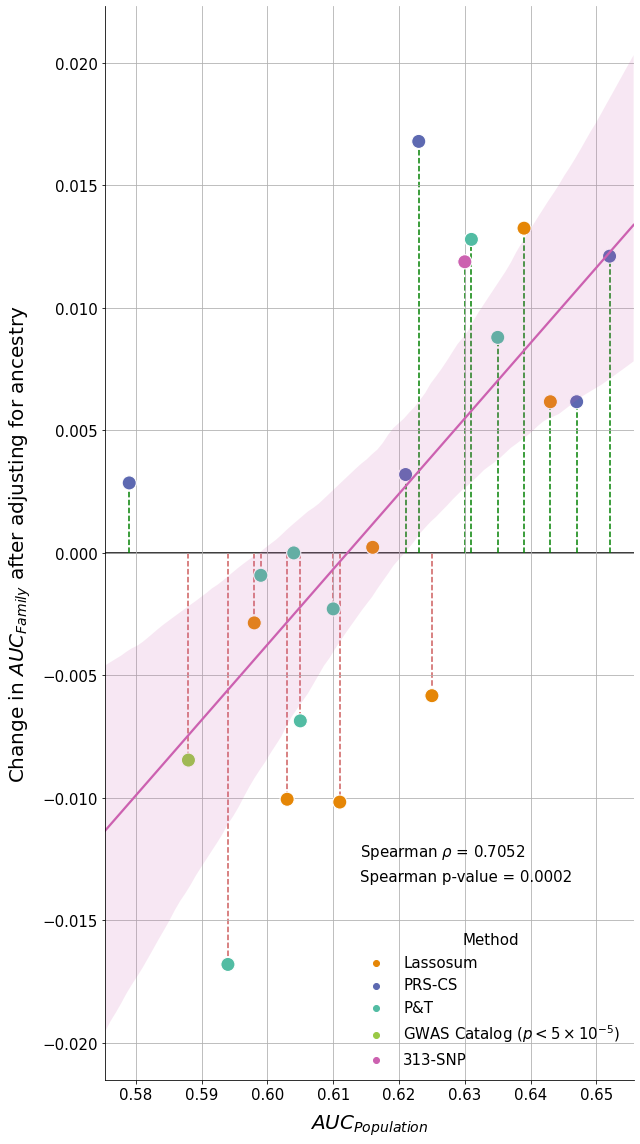

In [41]:
fig,ax = plt.subplots(figsize=(9,16))

col_x = "AUC Estimate"
col_y = "prs_adjusted_delta_first_fam"

ax.axhline(y=0,color="black",zorder=-16)
ax.set_axisbelow(True)


sns.scatterplot(
    data=prs_web_fam_df_merged,
    x=col_x,
    y=col_y,
    hue="Method",
    ax=ax,
    s=200,
    palette=prs_method_color_palette
)

for idx,row in prs_web_fam_df_merged.iterrows():
    x_coord = row[col_x]
    y_coord = row[col_y]
    color = "green" if y_coord > 0 else "indianred"
    ax.plot([x_coord,x_coord],[0,y_coord],linestyle="--",color=color,zorder=-15)

ax.set_axisbelow(True)
sns.regplot(
    data=prs_web_fam_df_merged,
    x=col_x,
    y=col_y,
    marker='',
    line_kws={"color":Vivid_5.mpl_colors[4]},
    ax=ax,
    truncate=False,
)


sns.move_legend(ax,"lower right",frameon=False,fontsize=medium_font,title_fontsize=medium_font)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel("$AUC_{Population}$",size=large_font,labelpad=10)
ax.set_ylabel("Change in $AUC_{Family}$ after adjusting for ancestry",size=large_font,labelpad=10)


ax.grid(axis="x")
ax.grid(axis="y")


ax.tick_params(axis='both', which='major', labelsize=medium_font)

x = prs_web_fam_df_merged[col_x].to_numpy()
y = prs_web_fam_df_merged[col_y].to_numpy()
nas = np.logical_or(np.isnan(x), np.isnan(y))
r, p = stats.spearmanr(x[~nas],y[~nas],alternative="greater")


ax.annotate(r"Spearman p-value = "+ f"{round(p,4)}",(0.614,-0.0134),size=medium_font)
ax.annotate(r"Spearman $\rho$ = "+ f"{round(r,4)}",(0.614,-0.0124),size=medium_font)

plt.tight_layout()
plt.savefig("figures/fig_4_prs_auc_delta.png",dpi=300)#,bbox_layout="tight")
plt.savefig("figures/fig_4_prs_auc_delta.eps",dpi=300)#,bbox_layout="tight")



# Figure 5 (PRS Distributiin between PV and Non-PV)

Patients with first degree family history of breast were more likely to carry PV

In [42]:
df_viz = clinical_df_filtered.copy()
pv_first_bc_ct = pd.crosstab(
    df_viz["FirstDegreeBC"].astype(bool),
    df_viz["Patho_Short_Variant_Carrier"].astype(bool)
)
pv_first_bc_ct

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Patho_Short_Variant_Carrier,False,True
FirstDegreeBC,,
False,148,27
True,18,7


In [43]:
bc_pv = pv_first_bc_ct[True][True]
bc_npv = pv_first_bc_ct[True][False]
nbc_pv = pv_first_bc_ct[False][True]
nbc_npv = pv_first_bc_ct[False][False]

test_table = Table2x2(
    [[bc_pv,bc_npv],[nbc_pv,nbc_npv]],
)

print("Odds Ratio and Fisher pval:")
print(stats.fisher_exact([[bc_pv,bc_npv],[nbc_pv,nbc_npv]],alternative="greater"))
print("Odds Ratio confidence interval")
print(test_table.oddsratio_confint())


Odds Ratio and Fisher pval:
(2.1316872427983538, 0.10378683562876682)
Odds Ratio confidence interval
(0.8124732727117303, 5.592910750088778)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
clinical_df_filtered.loc[
    (clinical_df_filtered["FirstDegreeBC"] == True) & (clinical_df_filtered["Patho_Short_Variant_Carrier"] == True),
    "fam_patho_group"
] = "First Degree BC, PV Carrier"

clinical_df_filtered.loc[
    (clinical_df_filtered["FirstDegreeBC"] == True) & (clinical_df_filtered["Patho_Short_Variant_Carrier"] == False),
    "fam_patho_group"
] = "First Degree BC, No PV"

clinical_df_filtered.loc[
    (clinical_df_filtered["FirstDegreeBC"] == False) & (clinical_df_filtered["Patho_Short_Variant_Carrier"] == True),
    "fam_patho_group"
] = "No First Degree BC, PV Carrier"

clinical_df_filtered.loc[
    (clinical_df_filtered["FirstDegreeBC"] == False) & (clinical_df_filtered["Patho_Short_Variant_Carrier"] == False),
    "fam_patho_group"
] = "No First Degree BC, No PV"

clinical_df_filtered.groupby("fam_patho_group")["Age",prs_to_use_adjusted_std].describe()



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-44-a288d852a8b0>:21: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  clinical_df_filtered.groupby("fam_patho_group")["Age",prs_to_use_adjusted_std].describe()
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/nanops.py:1723: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 

Age                                          \
                                count       mean        std   min   25%   50%   
fam_patho_group                                                                 
First Degree BC, No PV           18.0  49.000000   8.898116  32.0  46.0  51.0   
First Degree BC, PV Carrier       7.0  45.714286  11.586116  24.0  41.0  50.0   
No First Degree BC, No PV       148.0  48.750000  10.395495  25.0  41.0  49.0   
No First Degree BC, PV Carrier   27.0  42.629630   6.697578  31.0  37.0  44.0   

                                            \
                                 75%   max   
fam_patho_group                              
First Degree BC, No PV          56.0  60.0   
First Degree BC, PV Carrier     52.5  59.0   
No First Degree BC, No PV       56.0  73.0   
No First Degree BC, PV Carrier  47.0  57.0   

                               PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608_raw_standardized_residual_standardized  \
                                                                                                                                  count   
fam_patho_group                                                                                                                           
First Degree BC, No PV                                                       18.0                                                         
First Degree BC, PV Carrier                                                   7.0                                                         
No First Degree BC, No PV                                                   148.0                                                         
No First Degree BC, PV Carrier                                               27.0                                                         

                                                                        \
                                    mean       std       min       25%   
fam_patho_group                                                          
First Degree BC, No PV          0.903667  0.891940 -0.950330  0.409646   
First Degree BC, PV Carrier    -0.498329  1.274538 -1.971425 -1.315550   
No First Degree BC, No PV      -0.072189  0.975736 -2.450358 -0.748697   
No First Degree BC, PV Carrier -0.077548  0.841356 -1.973778 -0.783972   

                                                              
                                     50%       75%       max  
fam_patho_group                                               
First Degree BC, No PV          0.882282  1.670168  2.220738  
First Degree BC, PV Carrier    -0.873777  0.258738  1.470524  
No First Degree BC, No PV      -0.063760  0.572502  2.333184  
No First Degree BC, PV Carrier  0.061769  0.521262  1.528721

In [45]:
group_test_results = []

groups_to_test = clinical_df_filtered["fam_patho_group"].dropna().unique()

for group_1 in groups_to_test:
    for group_2 in groups_to_test:
        if group_1!=group_2:
            group_1_prs = clinical_df_filtered[clinical_df_filtered["fam_patho_group"]==group_1][prs_to_use_adjusted_std].to_numpy()
            group_2_prs = clinical_df_filtered[clinical_df_filtered["fam_patho_group"]==group_2][prs_to_use_adjusted_std].to_numpy()
            g1_len = len(group_1_prs)
            g2_len = len(group_2_prs)
            _,mwu_pval = stats.mannwhitneyu(group_1_prs,group_2_prs,nan_policy="omit")
            group_test_results.append([group_1,group_2,g1_len,g2_len,mwu_pval])
            
fam_hist_prs = clinical_df_filtered[clinical_df_filtered["FirstDegreeBC"]==True][prs_to_use_adjusted_std]
no_fam_hist_prs = clinical_df_filtered[clinical_df_filtered["FirstDegreeBC"]==False][prs_to_use_adjusted_std]
_,fam_mwu_pval = stats.mannwhitneyu(fam_hist_prs,no_fam_hist_prs,nan_policy="omit")
group_test_results.append(["First Degree BC","No First Degree BC",len(fam_hist_prs),len(no_fam_hist_prs),fam_mwu_pval])

group_test_df = pd.DataFrame(columns=["group_1","group_2","group_1_count","group_2_count","mwu_pval"],data=group_test_results)
group_test_df


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,group_1,group_2,group_1_count,group_2_count,mwu_pval
0,"No First Degree BC, PV Carrier","First Degree BC, No PV",27,18,0.000815
1,"No First Degree BC, PV Carrier","No First Degree BC, No PV",27,148,0.952239
2,"No First Degree BC, PV Carrier","First Degree BC, PV Carrier",27,7,0.314183
3,"First Degree BC, No PV","No First Degree BC, PV Carrier",18,27,0.000815
4,"First Degree BC, No PV","No First Degree BC, No PV",18,148,0.000165
5,"First Degree BC, No PV","First Degree BC, PV Carrier",18,7,0.020533
6,"No First Degree BC, No PV","No First Degree BC, PV Carrier",148,27,0.952239
7,"No First Degree BC, No PV","First Degree BC, No PV",148,18,0.000165
8,"No First Degree BC, No PV","First Degree BC, PV Carrier",148,7,0.252416
9,"First Degree BC, PV Carrier","No First Degree BC, PV Carrier",7,27,0.314183


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/utils.py:387: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles


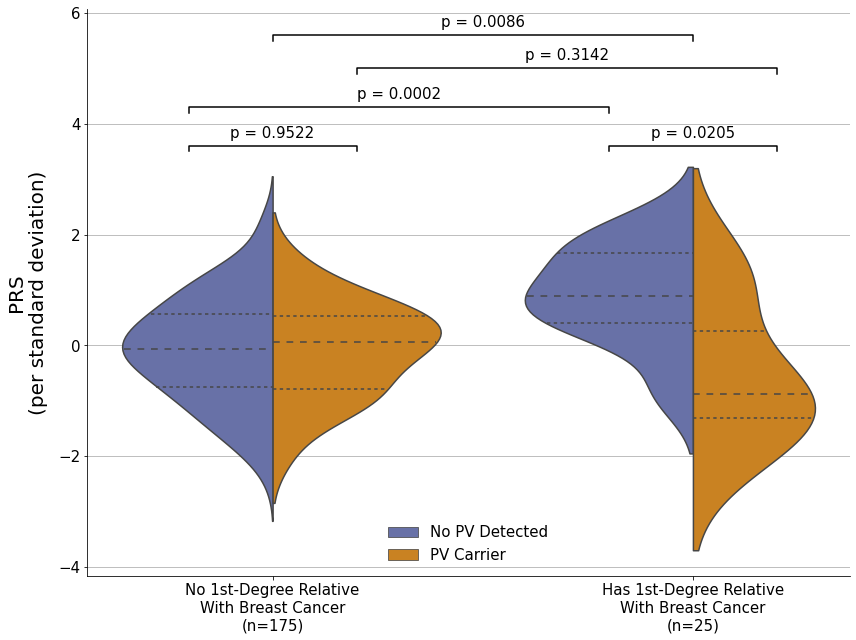

In [47]:
def add_stat_bar(ax,bar_x1,bar_x2,bar_y1,bar_y2,bar_y_top,text="ns",bar_color="black",text_offset=0.5,text_size=medium_font):
    ax.plot([bar_x1, bar_x1, bar_x2, bar_x2], [bar_y1, bar_y_top, bar_y_top, bar_y2], lw=1.5, c=bar_color)
    ax.text((bar_x1+bar_x2)*.5, bar_y_top+text_offset, text, ha='center', va='bottom', color=bar_color,size=text_size)
    return ax

clinical_df_filtered_interaction_plot = clinical_df_filtered.copy()

clinical_df_filtered_interaction_plot["Patho_Short_Variant_Carrier"] = clinical_df_filtered_interaction_plot["Patho_Short_Variant_Carrier"].replace({
    True: "PV Carrier",
    False: "No PV Detected"
})

clinical_df_filtered_interaction_plot["FirstDegreeBC"] = clinical_df_filtered_interaction_plot["FirstDegreeBC"].replace({
    True: f"Has 1st-Degree Relative\nWith Breast Cancer\n(n={clinical_df_filtered_interaction_plot['FirstDegreeBC'].sum()})",
    False: f"No 1st-Degree Relative\nWith Breast Cancer\n(n={clinical_df_filtered_interaction_plot['FirstDegreeBC'].notna().sum() - clinical_df_filtered_interaction_plot['FirstDegreeBC'].sum()})"
})

fig,ax = plt.subplots(figsize=(12,9))

hue_colors = {
    "No PV Detected":Vivid_5.mpl_colors[1],
    "PV Carrier":Vivid_5.mpl_colors[0]
}

ax.set_axisbelow(True)

sns.violinplot(
    data=clinical_df_filtered_interaction_plot,x="FirstDegreeBC",
    y=prs_to_use_adjusted_std,
    hue="Patho_Short_Variant_Carrier",
    hue_order=["No PV Detected","PV Carrier"],
    split=True,
    inner="quartile",
    ax=ax,
    zorder=3,
    palette=hue_colors
)


ax.set_axisbelow(True)
ax.grid(axis="y")

ax.set_ylabel("PRS\n(per standard deviation)",size=large_font,labelpad=10)
ax.set_xlabel("")
#ax.set_xlabel("Has First-Degree Relative With Breast Cancer",size=large_font,labelpad=10)
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)


sns.move_legend(ax,title=None,loc="lower center",frameon=False,fontsize=medium_font)

pval_pv_npv_all = group_test_df[
    (group_test_df["group_1"] == "First Degree BC") & (group_test_df["group_2"] == "No First Degree BC")
]["mwu_pval"].item()
pval_pv_npv_all = f"p = {pval_pv_npv_all:.4f}"# if pval_pv_npv_all < 0.05 else "p > 0.05"

pval_bc_pv_npv = group_test_df[
    (group_test_df["group_1"] == "First Degree BC, No PV") & (group_test_df["group_2"] == "First Degree BC, PV Carrier")
]["mwu_pval"].item()
pval_bc_pv_npv = f"p = {pval_bc_pv_npv:.4f}"# if pval_bc_pv_npv < 0.05 else "p > 0.05"

pval_nbc_pv_npv = group_test_df[
    (group_test_df["group_1"] == "No First Degree BC, No PV") & (group_test_df["group_2"] == "No First Degree BC, PV Carrier")
]["mwu_pval"].item()
pval_nbc_pv_npv = f"p = {pval_nbc_pv_npv:.4f}"# if pval_nbc_pv_npv < 0.05 else "p > 0.05"

pval_pv_bc_nbc = group_test_df[
    (group_test_df["group_1"] == "No First Degree BC, PV Carrier") & (group_test_df["group_2"] == "First Degree BC, PV Carrier")
]["mwu_pval"].item()
pval_pv_bc_nbc = f"p = {pval_pv_bc_nbc:.4f}"# if pval_pv_bc_nbc < 0.05 else "p > 0.05"

pval_npv_bc_nbc = group_test_df[
    (group_test_df["group_1"] == "First Degree BC, No PV") & (group_test_df["group_2"] == "No First Degree BC, No PV")
]["mwu_pval"].item()
pval_npv_bc_nbc = f"p = {pval_npv_bc_nbc:.4f}"# if pval_npv_bc_nbc < 0.05 else "p > 0.05"

add_stat_bar(ax,bar_x1=0,bar_x2=1,bar_y1=5.5,bar_y2=5.5,bar_y_top=5.6,text_offset=0.1,text=pval_pv_npv_all)

add_stat_bar(ax,bar_x1=-0.2,bar_x2=0.2,bar_y1=3.5,bar_y2=3.5,bar_y_top=3.6,text_offset=0.1,text=pval_nbc_pv_npv)
add_stat_bar(ax,bar_x1=1-0.2,bar_x2=1+0.2,bar_y1=3.5,bar_y2=3.5,bar_y_top=3.6,text_offset=0.1,text=pval_bc_pv_npv)

add_stat_bar(ax,bar_x1=-0.2,bar_x2=1-0.2,bar_y1=4.2,bar_y2=4.2,bar_y_top=4.3,text_offset=0.1,text=pval_npv_bc_nbc)
add_stat_bar(ax,bar_x1=0.2,bar_x2=1+0.2,bar_y1=4.9,bar_y2=4.9,bar_y_top=5.,text_offset=0.1,text=pval_pv_bc_nbc)


ax.tick_params(axis='both', which='major', labelsize=medium_font)

plt.tight_layout()
plt.savefig("figures/fig_5_rare_common_interaction.png",dpi=300)
plt.savefig("figures/fig_5_rare_common_interaction.eps",dpi=300)





# Figure 6 (Age and PRS Correlation)

## Plot the correlation of Age and PRS conditioned on Family history and PV carrier status

In [48]:
from palettable.cartocolors.diverging import Tropic_7
from palettable.cartocolors.qualitative import Prism_7

prs_to_plot = prs_to_use_adjusted_std

hue_colors = {
    "nbc_npv": sns.color_palette("Paired")[0], #"gray", #Vivid_5.mpl_colors[1],
    "nbc_pv": sns.color_palette("Paired")[1], #"orange", # Vivid_5.mpl_colors[1],
    "bc_npv": sns.color_palette("Paired")[5], #"blue", #Vivid_5.mpl_colors[1],
    "bc_pv":sns.color_palette("Paired")[4], #Vivid_5.mpl_colors[3]
}

all_r, all_p = stats.spearmanr(
    clinical_df_filtered[prs_to_plot].to_numpy(),
    clinical_df_filtered["Age"].to_numpy(),
    alternative="less"
)

fam_subset = clinical_df_filtered[
    (clinical_df_filtered["FirstDegreeBC"]==True)
].copy()


fam_patho_subset = clinical_df_filtered[
    (clinical_df_filtered["FirstDegreeBC"]==True)&
    (clinical_df_filtered["Patho_Short_Variant_Carrier"]==True)
].copy()

fam_patho_r, fam_patho_p = stats.spearmanr(
    fam_patho_subset[prs_to_plot].to_numpy(),
    fam_patho_subset["Age"].to_numpy(),
    alternative="less"
)

fam_no_patho_subset = clinical_df_filtered[
    (clinical_df_filtered["FirstDegreeBC"]==True)&
    (clinical_df_filtered["Patho_Short_Variant_Carrier"]==False)
].copy()

fam_no_patho_r, fam_no_patho_p = stats.spearmanr(
    fam_no_patho_subset[prs_to_plot].to_numpy(),
    fam_no_patho_subset["Age"].to_numpy(),
    alternative="less"
)


no_fam_patho_subset = clinical_df_filtered[
    (clinical_df_filtered["FirstDegreeBC"]==False)&
    (clinical_df_filtered["Patho_Short_Variant_Carrier"]==True)
].copy()

no_fam_patho_r, no_fam_patho_p = stats.spearmanr(
    no_fam_patho_subset[prs_to_plot].to_numpy(),
    no_fam_patho_subset["Age"].to_numpy(),
    alternative="less"
)

no_fam_no_patho_subset = clinical_df_filtered[
    (clinical_df_filtered["FirstDegreeBC"]==False)&
    (clinical_df_filtered["Patho_Short_Variant_Carrier"]==False)
].copy()

no_fam_no_patho_r, no_fam_no_patho_p = stats.spearmanr(
    no_fam_no_patho_subset[prs_to_plot].to_numpy(),
    no_fam_no_patho_subset["Age"].to_numpy(),
    alternative="less"
)

def plot_age_prs_assoc(
    full_df,
    subset_df,
    prs_to_plot,
    label_text,
    ax,
    subset_color,
    add_all_label=False
):    
    all_r, all_p = stats.spearmanr(
        full_df[prs_to_plot].to_numpy(),
        full_df["Age"].to_numpy(),
        alternative="less"
    )

    subset_r, subset_p = stats.spearmanr(
        subset_df[prs_to_plot].to_numpy(),
        subset_df["Age"].to_numpy(),
        alternative="less"
    )
    
    sns.scatterplot(
        data=full_df,
        x=prs_to_plot,
        y="Age",
        ax=ax,
        marker=''
    )
    ax.set_xlim((-3,3))
    
    all_label = None
    if add_all_label:
        all_label = f"Entire cohort\n(n={len(full_df)},rho={round(all_r,3)},p={round(all_p,3)})"

    ax0 = sns.regplot(
        data=full_df,
        x=prs_to_plot,
        y="Age",
        truncate=False,
        ax=ax,
        color="gray", #hue_colors["nbc_npv"],
        label=all_label,
        scatter_kws={
            's':100,
            "alpha":0.2,
            #"edgecolors":"black",
            #"linewidths":2
        },
        line_kws={
            "linestyle":"--",
            "color":"gray"
        },
        ci=0,
    )

    ax1 = sns.regplot(
        data=subset_df,
        x=prs_to_plot,
        y="Age",
        truncate=False,
        ax=ax,
        color=subset_color,
        label=f"{label_text}\n(n={len(subset_df)},rho={round(subset_r,3)},p={round(subset_p,3)})",
        scatter_kws={
            's':100,
            "edgecolors":"black",
            "linewidths":2
        },
        line_kws={
            "linestyle":"-" if subset_p < 0.05 else "--", 
            "color":subset_color #if no_fam_no_patho_p < 0.05 else "gray" 
        },
        ci=95# if subset_p < 0.05 else 0 ,
    )
    
    ax.set_ylim((20,80))
    ax.set_axisbelow(True)
    ax.tick_params(axis='both', which='major', labelsize=large_font)

    ax.grid(axis="y")
    ax.grid(axis="x")
    
    ax.set_title(f"{label_text}\n(n={len(subset_df)},rho={round(subset_r,3)},p={round(subset_p,3)})",size=large_font)
    ax.set_xlabel("PRS\n(per standard deviation)",size=large_font,labelpad=10)
    ax.set_ylabel("Age at Presentation",size=large_font,labelpad=10)
    
    return ax


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.color

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


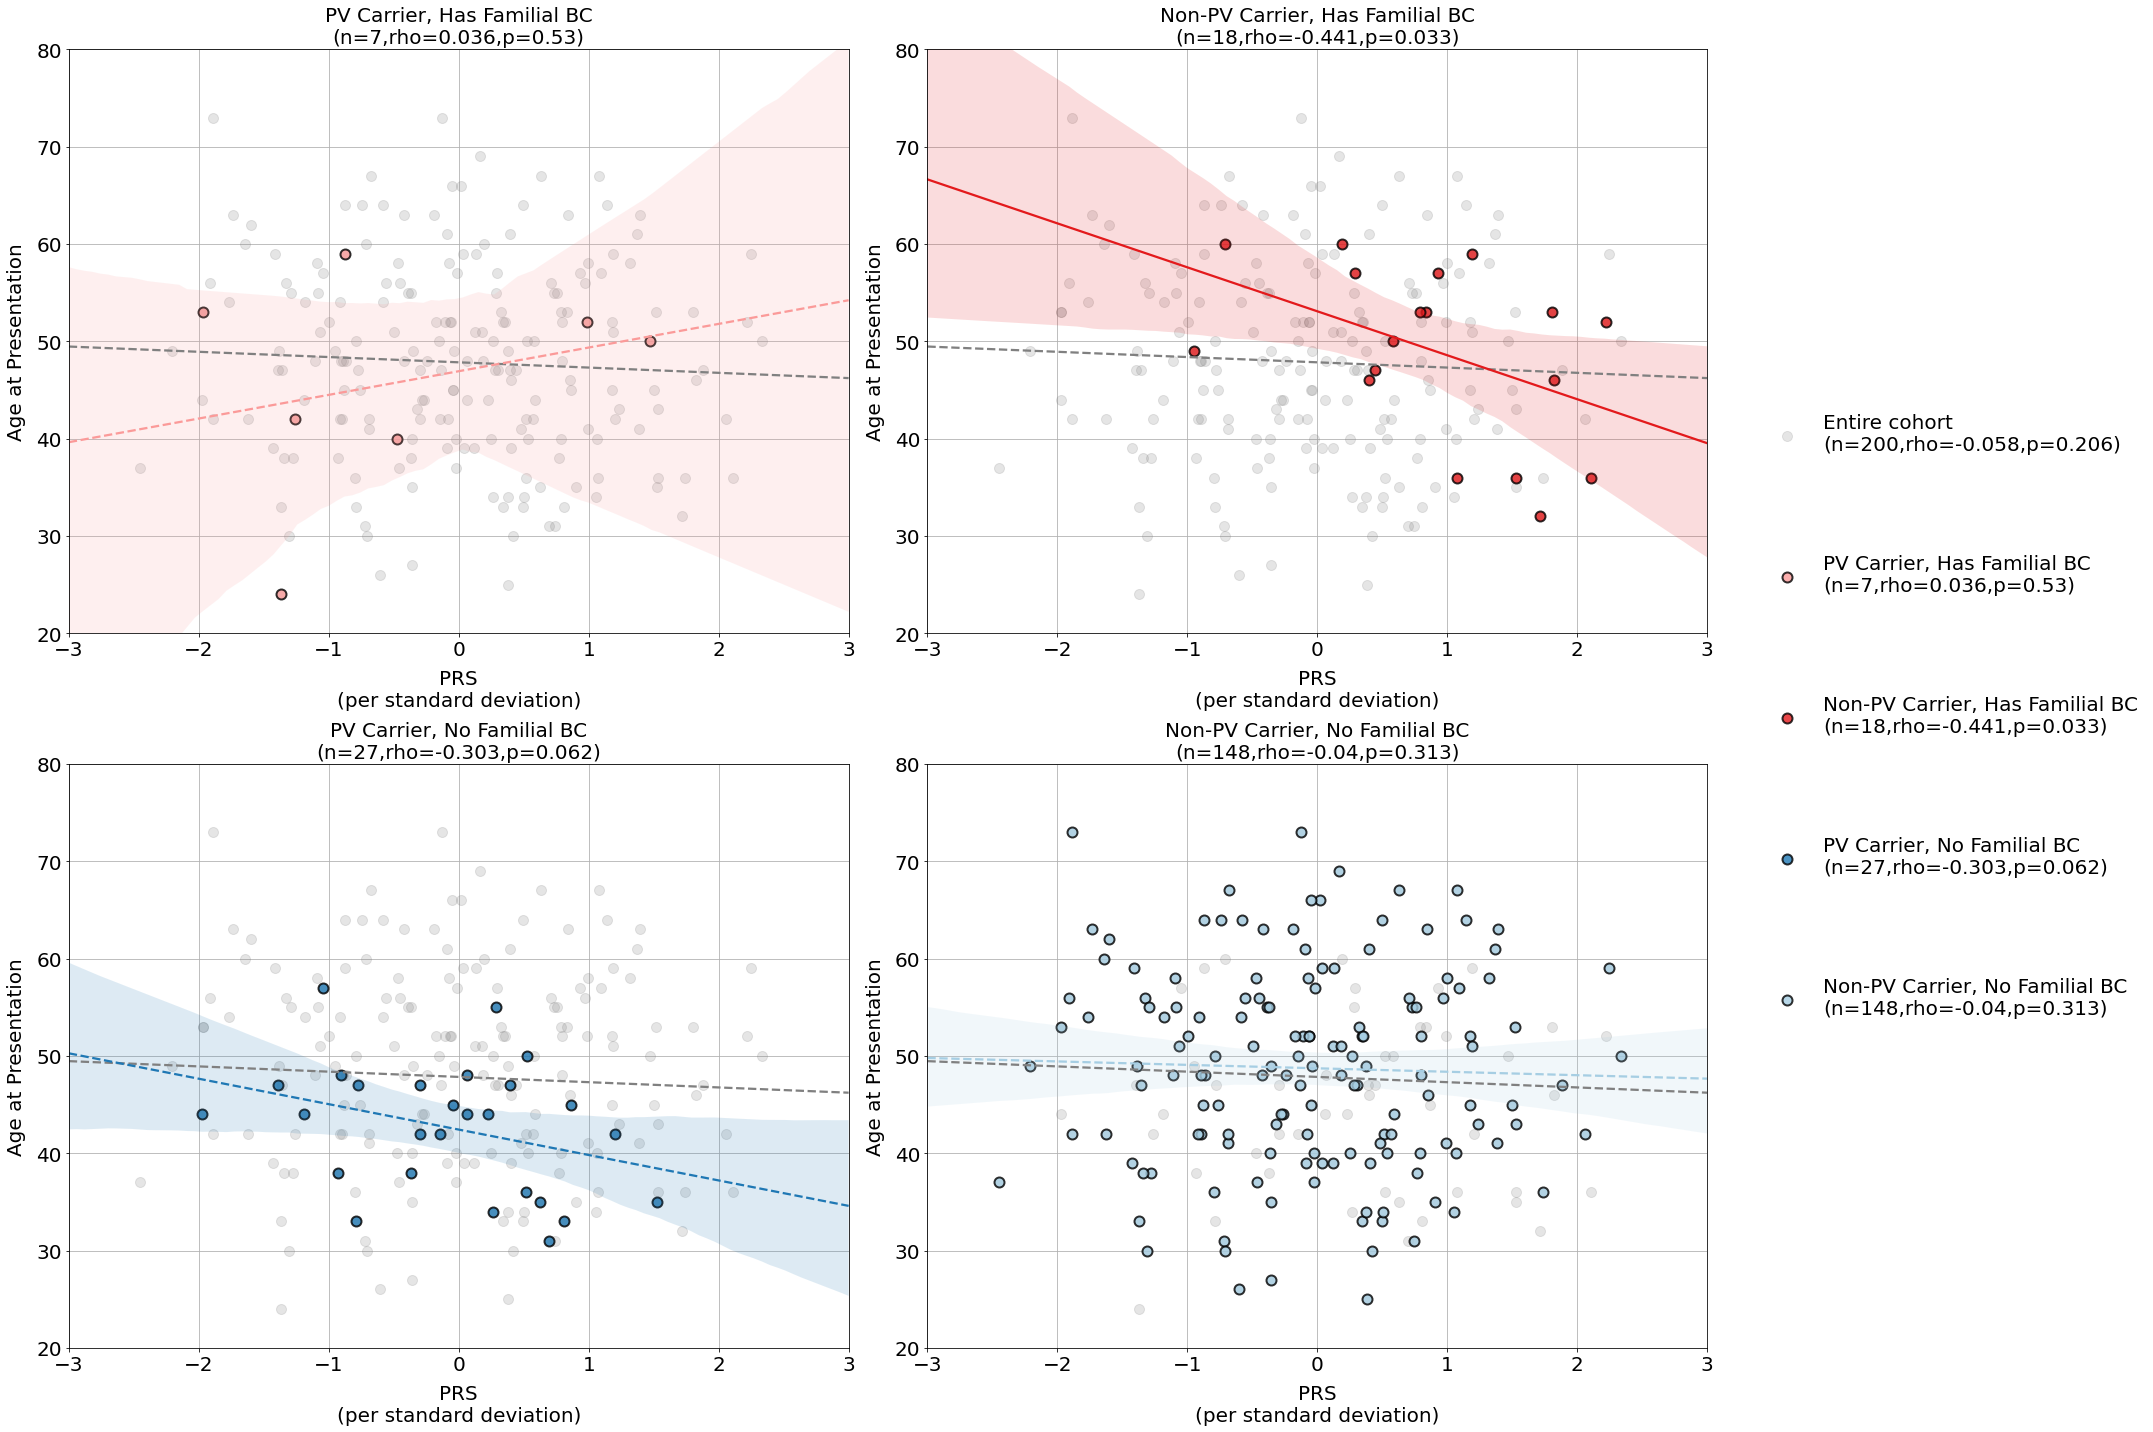

In [49]:
fig,axes = plt.subplots(
    figsize=(24,20),
    ncols=2,
    nrows=2,
)

plot_age_prs_assoc(
    full_df=clinical_df_filtered,
    subset_df=fam_patho_subset,
    prs_to_plot=prs_to_plot,
    label_text="PV Carrier, Has Familial BC",
    ax=axes[0,0],
    subset_color=hue_colors["bc_pv"],
    add_all_label=True
)

plot_age_prs_assoc(
    full_df=clinical_df_filtered,
    subset_df=fam_no_patho_subset,
    prs_to_plot=prs_to_plot,
    label_text="Non-PV Carrier, Has Familial BC",
    ax=axes[0,1],
    subset_color=hue_colors["bc_npv"]
)

plot_age_prs_assoc(
    full_df=clinical_df_filtered,
    subset_df=no_fam_patho_subset,
    prs_to_plot=prs_to_plot,
    label_text="PV Carrier, No Familial BC",
    ax=axes[1,0],
    subset_color=hue_colors["nbc_pv"]
)

plot_age_prs_assoc(
    full_df=clinical_df_filtered,
    subset_df=no_fam_no_patho_subset,
    prs_to_plot=prs_to_plot,
    label_text="Non-PV Carrier, No Familial BC",
    ax=axes[1,1],
    subset_color=hue_colors["nbc_npv"]
)

fig.legend(
    frameon=False,
    ncol=1,
    loc='center right',
    fontsize=large_font,
    title_fontsize=large_font,
    bbox_to_anchor=(1.25,0.5),
    #borderpad=5,
    labelspacing=5
)

fig.tight_layout(pad=5.0)

plt.tight_layout()
plt.savefig("figures/fig_6_age_prs_interaction.png",dpi=300)
plt.savefig("figures/fig_6_age_prs_interaction.eps",dpi=300)

#plt.savefig("supplementary_figures/PGS000004/fig_6_age_prs_interaction.png",dpi=300)
#plt.savefig("supplementary_figures/PGS000004/fig_6_age_prs_interaction.eps",dpi=300)


### Check the exact effect of PRS on age of onset among people with first degree BC and no pathogenic variants


In [50]:
clinical_df_filtered_subset = clinical_df_filtered[
    (clinical_df_filtered["FirstDegreeBC"]==True)
    &(clinical_df_filtered["Patho_Short_Variant_Carrier"]==False)
].copy()

clinical_df_filtered_subset = clinical_df_filtered_subset[clinical_df_filtered_subset["Age"].notna()]

X = clinical_df_filtered_subset[prs_to_use_adjusted_std]
y = clinical_df_filtered_subset["Age"]

X2 = sm.add_constant(X)

gaussian_model = sm.GLM(y, X2,family=sm.families.Gaussian())
gaussian_results = gaussian_model.fit()

print(gaussian_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                    Age   No. Observations:                   18
Model:                            GLM   Df Residuals:                       16
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          66.864
Method:                          IRLS   Log-Likelihood:                -62.305
Date:                Tue, 28 Mar 2023   Deviance:                       1069.8
Time:                        22:48:59   Pearson chi2:                 1.07e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2103
Covariance Type:            nonrobust                                         
                                                                                                               coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Same analysis but among people without first degree BC and has pathogenic variants

In [52]:
clinical_df_filtered_subset = clinical_df_filtered[
    (clinical_df_filtered["FirstDegreeBC"]==False)
    &(clinical_df_filtered["Patho_Short_Variant_Carrier"]==True)
].copy()

clinical_df_filtered_subset = clinical_df_filtered_subset[clinical_df_filtered_subset["Age"].notna()]

X = clinical_df_filtered_subset[prs_to_use_adjusted_std]
y = clinical_df_filtered_subset["Age"]

X2 = sm.add_constant(X)

gaussian_model = sm.GLM(y, X2,family=sm.families.Gaussian())
gaussian_results = gaussian_model.fit()

print(gaussian_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                    Age   No. Observations:                   27
Model:                            GLM   Df Residuals:                       25
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          41.624
Method:                          IRLS   Log-Likelihood:                -87.610
Date:                Tue, 28 Mar 2023   Deviance:                       1040.6
Time:                        22:49:06   Pearson chi2:                 1.04e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1084
Covariance Type:            nonrobust                                         
                                                                                                               coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Supplemental Figure 2 (Check effect of carrying PV on age of onset)

In [53]:
group_test_results_pv = []
groups_to_test = clinical_df_filtered["fam_patho_group"].dropna().unique()

for group_1 in groups_to_test:
    for group_2 in groups_to_test:
        if group_1!=group_2:
            group_1_age = clinical_df_filtered[clinical_df_filtered["fam_patho_group"]==group_1]["Age"].to_numpy()
            group_2_age = clinical_df_filtered[clinical_df_filtered["fam_patho_group"]==group_2]["Age"].to_numpy()
            #print(group_2_prs)
            g1_mean = group_1_age.mean()
            g2_mean = group_2_age.mean()
            _,mwu_pval = stats.mannwhitneyu(group_1_age,group_2_age,nan_policy="omit")
            group_test_results_pv.append([group_1,group_2,g1_mean,g2_mean,mwu_pval])
            
pv_age = clinical_df_filtered[clinical_df_filtered["Patho_Short_Variant_Carrier"]==True]["Age"]
no_pv_age = clinical_df_filtered[clinical_df_filtered["Patho_Short_Variant_Carrier"]==False]["Age"]
_,pv_mwu_pval = stats.mannwhitneyu(pv_age,no_pv_age,nan_policy="omit")
group_test_results_pv.append(["PV Carrier","Non-PV Carrier",pv_age.mean(),no_pv_age.mean(),pv_mwu_pval])

pv_test_df = pd.DataFrame(columns=["group_1","group_2","g1_mean","g2_mean","mwu_pval"],data=group_test_results_pv)
pv_test_df


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,group_1,group_2,g1_mean,g2_mean,mwu_pval
0,"No First Degree BC, PV Carrier","First Degree BC, No PV",42.629630,49.000000,0.007335
1,"No First Degree BC, PV Carrier","No First Degree BC, No PV",42.629630,48.750000,0.002638
2,"No First Degree BC, PV Carrier","First Degree BC, PV Carrier",42.629630,45.714286,0.266808
3,"First Degree BC, No PV","No First Degree BC, PV Carrier",49.000000,42.629630,0.007335
4,"First Degree BC, No PV","No First Degree BC, No PV",49.000000,48.750000,0.813097
5,"First Degree BC, No PV","First Degree BC, PV Carrier",49.000000,45.714286,0.563811
6,"No First Degree BC, No PV","No First Degree BC, PV Carrier",48.750000,42.629630,0.002638
7,"No First Degree BC, No PV","First Degree BC, No PV",48.750000,49.000000,0.813097
8,"No First Degree BC, No PV","First Degree BC, PV Carrier",48.750000,45.714286,0.647684
9,"First Degree BC, PV Carrier","No First Degree BC, PV Carrier",45.714286,42.629630,0.266808


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/utils.py:387: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles


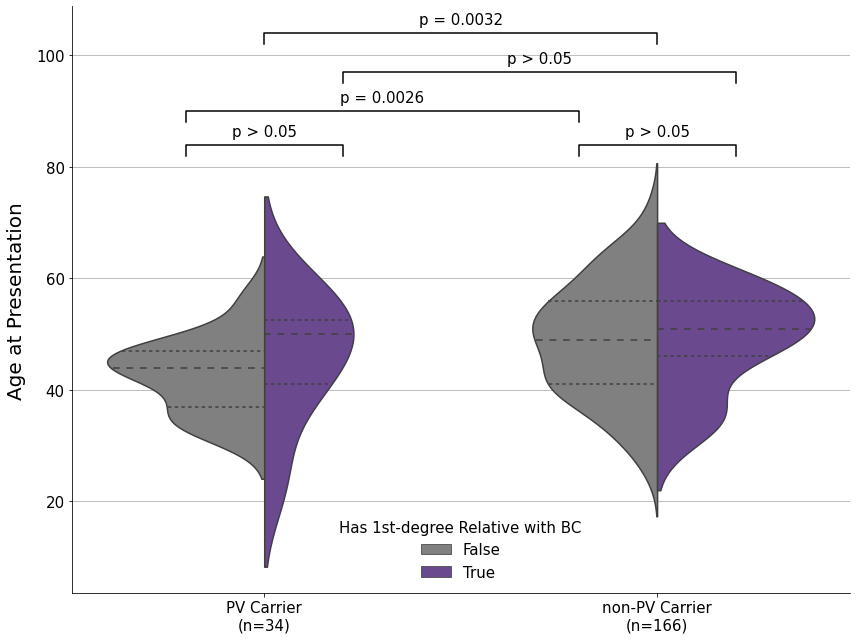

In [54]:
clinical_df_filtered_interaction_plot = clinical_df_filtered.copy()

pv_total = clinical_df_filtered_interaction_plot['Patho_Short_Variant_Carrier'].sum()
non_pv_total = clinical_df_filtered_interaction_plot['Patho_Short_Variant_Carrier'].notna().sum() - pv_total

clinical_df_filtered_interaction_plot["Patho_Short_Variant_Carrier"] = clinical_df_filtered_interaction_plot["Patho_Short_Variant_Carrier"].replace({
    True: f"PV Carrier\n(n={pv_total})",
    False: f"non-PV Carrier\n(n={non_pv_total})",
})

clinical_df_filtered_interaction_plot["Has 1st-degree Relative with BC"] = clinical_df_filtered_interaction_plot["FirstDegreeBC"].replace({
    True: "True",
    False: "False"
})

fig,ax = plt.subplots(figsize=(12,9))

hue_colors = {
    "True":Paired_10.mpl_colors[9],#Vivid_5.mpl_colors[0],
    "False":"gray" #Vivid_5.mpl_colors[1]
}

ax.set_axisbelow(True)

sns.violinplot(
    data=clinical_df_filtered_interaction_plot,x="Patho_Short_Variant_Carrier",
    y="Age",
    hue="Has 1st-degree Relative with BC",
    hue_order=["False","True"],
    split=True,
    inner="quartile",
    ax=ax,
    zorder=3,
    palette=hue_colors
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2])

ax.set_axisbelow(True)
ax.grid(axis="y")

ax.set_ylabel("Age at Presentation",size=large_font,labelpad=10)
ax.set_xlabel("")
#ax.set_xlabel("Has First-Degree Relative With Breast Cancer",size=large_font,labelpad=10)
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)


sns.move_legend(ax,loc="lower center",frameon=False,fontsize=medium_font,title="Has 1st-degree Relative with BC",title_fontsize=medium_font)

pval_pv_npv_all = pv_test_df[
    (pv_test_df["group_1"] == "PV Carrier") & (pv_test_df["group_2"] == "Non-PV Carrier")
]["mwu_pval"].item()
pval_pv_npv_all = f"p = {pval_pv_npv_all:.4f}" if pval_pv_npv_all < 0.05 else "p > 0.05"

pval_bc_pv_npv = pv_test_df[
    (pv_test_df["group_1"] == "First Degree BC, No PV") & (pv_test_df["group_2"] == "First Degree BC, PV Carrier")
]["mwu_pval"].item()
pval_bc_pv_npv = f"p = {pval_bc_pv_npv:.4f}" if pval_bc_pv_npv < 0.05 else "p > 0.05"

pval_nbc_pv_npv = pv_test_df[
    (pv_test_df["group_1"] == "No First Degree BC, No PV") & (pv_test_df["group_2"] == "No First Degree BC, PV Carrier")
]["mwu_pval"].item()
pval_nbc_pv_npv = f"p = {pval_nbc_pv_npv:.4f}" if pval_nbc_pv_npv < 0.05 else "p > 0.05"

pval_pv_bc_nbc = pv_test_df[
    (pv_test_df["group_1"] == "No First Degree BC, PV Carrier") & (pv_test_df["group_2"] == "First Degree BC, PV Carrier")
]["mwu_pval"].item()
pval_pv_bc_nbc = f"p = {pval_pv_bc_nbc:.4f}" if pval_pv_bc_nbc < 0.05 else "p > 0.05"

pval_npv_bc_nbc = pv_test_df[
    (pv_test_df["group_1"] == "First Degree BC, No PV") & (pv_test_df["group_2"] == "No First Degree BC, No PV")
]["mwu_pval"].item()
pval_npv_bc_nbc = f"p = {pval_npv_bc_nbc:.4f}" if pval_npv_bc_nbc < 0.05 else "p > 0.05"

add_stat_bar(ax,bar_x1=0,bar_x2=1,bar_y1=102,bar_y2=102,bar_y_top=104,text_offset=1,text=pval_pv_npv_all)

add_stat_bar(ax,bar_x1=-0.2,bar_x2=0.2,bar_y1=82,bar_y2=82,bar_y_top=84,text_offset=1,text=pval_pv_bc_nbc)
add_stat_bar(ax,bar_x1=1-0.2,bar_x2=1+0.2,bar_y1=82,bar_y2=82,bar_y_top=84,text_offset=1,text=pval_npv_bc_nbc)

add_stat_bar(ax,bar_x1=-0.2,bar_x2=1-0.2,bar_y1=88,bar_y2=88,bar_y_top=90,text_offset=1,text=pval_nbc_pv_npv)
add_stat_bar(ax,bar_x1=0.2,bar_x2=1+0.2,bar_y1=95,bar_y2=95,bar_y_top=97,text_offset=1,text=pval_bc_pv_npv)


ax.tick_params(axis='both', which='major', labelsize=medium_font)

plt.tight_layout()
plt.savefig("supplementary_figures/PV_carrier_status_on_age_of_onset.png",dpi=300)
plt.savefig("supplementary_figures/PV_carrier_status_on_age_of_onset.eps",dpi=300)




# Figure 7 (Effects of Accounting for PV Carrier)

In [55]:
prs_to_use_decile = f"{prs_to_use_adjusted}_Decile"

prs_deciles = pd.qcut(clinical_df_filtered[prs_to_use_adjusted],q=10,labels=range(1,11))

clinical_df_filtered[prs_to_use_decile] = prs_deciles

clinical_df_filtered["population_adjusted_prs_std"] = clinical_df_filtered[prs_to_use_adjusted_std]
clinical_df_filtered["population_adjusted_prs_raw"] = clinical_df_filtered[prs_to_use_adjusted]
clinical_df_filtered


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ID,Age,Histology,CancerGrade,CancerStage_T,CancerStage_N,CancerStage_M,ER+,PR+,HER2+,...,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608_residual_standardized,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608_raw_residual,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608_raw_standardized_residual,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608_raw_standardized_raw,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608_raw_standardized_raw_standardized,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608_raw_standardized_residual_standardized,fam_patho_group,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LASSOSUM_MGI_20200608_raw_standardized_residual_Decile,population_adjusted_prs_std,population_adjusted_prs_raw
0,BC_P_001,47.0,4-Invasive lobular carcinoma,2-Grade 2,2-T2,0-No,0-M0,True,True,False,...,-0.777759,-1.165669e-06,-0.737352,-1.071499,-1.071499,-0.777759,"No First Degree BC, PV Carrier",3,-0.777759,-0.737352
1,BC_P_002,47.0,4-Invasive lobular carcinoma,2-Grade 2,3-T3,1-N1,0-M0,True,False,False,...,0.442861,6.637397e-07,0.419853,0.421336,0.421336,0.442861,"First Degree BC, No PV",7,0.442861,0.419853
2,BC_P_003,44.0,3-Invasive ductal carcinoma,3-Grade 3,3-T3,0-No,0-M0,False,False,False,...,-1.190310,-1.783982e-06,-1.128471,-0.841249,-0.841249,-1.190310,"No First Degree BC, PV Carrier",2,-1.190310,-1.128471
3,BC_P_004,57.0,2-Lobular carcinoma in situ,2-Grade 2,1-T1c,0-No,0-M0,True,True,False,...,1.092739,1.637747e-06,1.035969,0.952684,0.952684,1.092739,"No First Degree BC, No PV",9,1.092739,1.035969
4,BC_P_005,47.0,3-Invasive ductal carcinoma,2-Grade 2,2-T2,0-No,0-M0,False,False,True,...,-0.137074,-2.054409e-07,-0.129953,-0.135315,-0.135315,-0.137074,"No First Degree BC, No PV",5,-0.137074,-0.129953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,BC_P_231,51.0,12- Other,2-Grade 2,1-T1c,0-No,0-M0,True,True,False,...,0.180187,2.700567e-07,0.170826,0.889428,0.889428,0.180187,"No First Degree BC, No PV",6,0.180187,0.170826
211,BC_P_232,61.0,1-Ductal carcinoma in situ,2-Grade 2,1-T1c,0-No,0-M0,True,True,False,...,0.395077,5.921236e-07,0.374552,0.547847,0.547847,0.395077,"No First Degree BC, No PV",7,0.395077,0.374552
212,BC_P_233,49.0,3-Invasive ductal carcinoma,3-Grade 3,1-T1c,1-N1,0-M0,True,True,False,...,-0.353830,-5.303044e-07,-0.335448,-0.407314,-0.407314,-0.353830,"No First Degree BC, No PV",4,-0.353830,-0.335448
215,BC_P_236,64.0,2-Lobular carcinoma in situ,2-Grade 2,1-T1c,0-No,0-M0,True,True,NaN,...,-0.875538,-1.312216e-06,-0.830052,-0.565454,-0.565454,-0.875538,"No First Degree BC, No PV",3,-0.875538,-0.830052


## Panel A) (Pre-removal)

In [56]:
### Creates the Odds ratio table required for the plot
def make_odds_ratio_table(df,prs_name,labels,num_q=5,merge_middle=False):
    odds_ratio_df_rows = []
    for label in labels_to_plot:
        no_na_df = df[df[label].notna()].copy()
        no_na_df[f"prs_disc"] = pd.qcut(no_na_df[prs_name],q=num_q,labels=range(1,num_q+1)).astype(float)
        for i in range(1,num_q+1):
            subset_df = no_na_df[no_na_df["prs_disc"]==i].copy()
            if merge_middle and i != 1 and i != num_q:
                subset_df = no_na_df[(no_na_df["prs_disc"]>0)&(no_na_df["prs_disc"]<num_q-1)].copy()
            num_case = subset_df[label].sum()
            num_total = len(subset_df[label])
            num_control = num_total - num_case
            mean = num_case/num_total

            quantile_text = f"Q{i}"
            if merge_middle and i != 1 and i != num_q:
                quantile_text = f"Q2-Q{num_q-1}"

            row = [label,i,quantile_text,num_case,num_control,num_total,mean]
            odds_ratio_df_rows.append(row)
    odds_ratio_df_cols = ["label","quantile_order","quantile_text","num_case","num_control","num_total","mean"]      
    odds_ratio_df = pd.DataFrame(columns=odds_ratio_df_cols,data=odds_ratio_df_rows)
    odds_ratio_df["percentage"] = odds_ratio_df["mean"]*100

    if merge_middle:
        odds_ratio_df = odds_ratio_df.drop_duplicates(subset=["label","quantile_text"]).copy()
        
    return odds_ratio_df

def create_pair_test_df(or_df):
    pair_test_df = or_df.copy()
    pair_test_rows = []
    for i in range(len(pair_test_df)):
        label_1 = pair_test_df["label"].iloc[i]
        for j in range(len(pair_test_df)):
            label_2 = pair_test_df["label"].iloc[j]
            if (label_1 == label_2) and (i!=j):
                a = pair_test_df["num_case"].iloc[i]
                b = pair_test_df["num_control"].iloc[i]
                c = pair_test_df["num_case"].iloc[j]
                d = pair_test_df["num_control"].iloc[j]
                res = calc_fisher(a,b,c,d)
                
                comp_1 = pair_test_df["quantile_text"].iloc[i]
                comp_2 = pair_test_df["quantile_text"].iloc[j]
                to_append = [label_1,comp_1,comp_2,a,b,c,d,res["OR"],res["OR_95CI_lower"],res["OR_95CI_upper"],res["p_val"]]
                pair_test_rows.append(to_append)

    pair_test_columns = ["label","group_1","group_2","group_1_case","group_1_control","group_2_case","group_2_control","OR","OR_95CI_lower","OR_95CI_upper","fisher_pval"]
    odds_ratio_pair_test_table = pd.DataFrame(columns=pair_test_columns,data=pair_test_rows)            
    return odds_ratio_pair_test_table

odds_ratio_df_plain = make_odds_ratio_table(
    clinical_df_filtered,
    prs_to_use_adjusted_std,
    labels_to_plot,
    num_q=10,
    merge_middle=True
)

odds_ratio_df_plain = odds_ratio_df_plain.replace({
    "FirstDegreeBC":"BC - First Degree",
    "AnyDegreeBC": "BC - Any Degree",
    "FamilyCancer_FirstDegree" :"Any Cancer - First Degree",
    "FamilyCancer_AnyDegree": "Any Cancer - Any Degree"
})

odds_ratio_pair_test_table = create_pair_test_df(odds_ratio_df_plain)
odds_ratio_pair_test_table



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,label,group_1,group_2,group_1_case,group_1_control,group_2_case,group_2_control,OR,OR_95CI_lower,OR_95CI_upper,fisher_pval
0,BC - First Degree,Q1,Q2-Q9,2,18,14,146,1.157706,0.1749,5.2618,0.693254
1,BC - First Degree,Q1,Q10,2,18,7,13,0.214593,0.0280,1.3422,0.127386
2,BC - First Degree,Q2-Q9,Q1,14,146,2,18,0.863777,0.1900,5.7167,0.693254
3,BC - First Degree,Q2-Q9,Q10,14,146,7,13,0.180816,0.0557,0.5675,0.003141
4,BC - First Degree,Q10,Q1,7,13,2,18,4.659986,0.7450,35.7334,0.127386
5,BC - First Degree,Q10,Q2-Q9,7,13,14,146,5.530473,1.7621,17.9669,0.003141
6,BC - Any Degree,Q1,Q2-Q9,4,16,38,122,0.803580,0.2339,2.5045,1.000000
7,BC - Any Degree,Q1,Q10,4,16,10,10,0.259302,0.0596,1.0790,0.095846
8,BC - Any Degree,Q2-Q9,Q1,38,122,4,16,1.244431,0.3993,4.2753,1.000000
9,BC - Any Degree,Q2-Q9,Q10,38,122,10,10,0.313896,0.1152,0.8465,0.028430


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/utils.py:387: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles


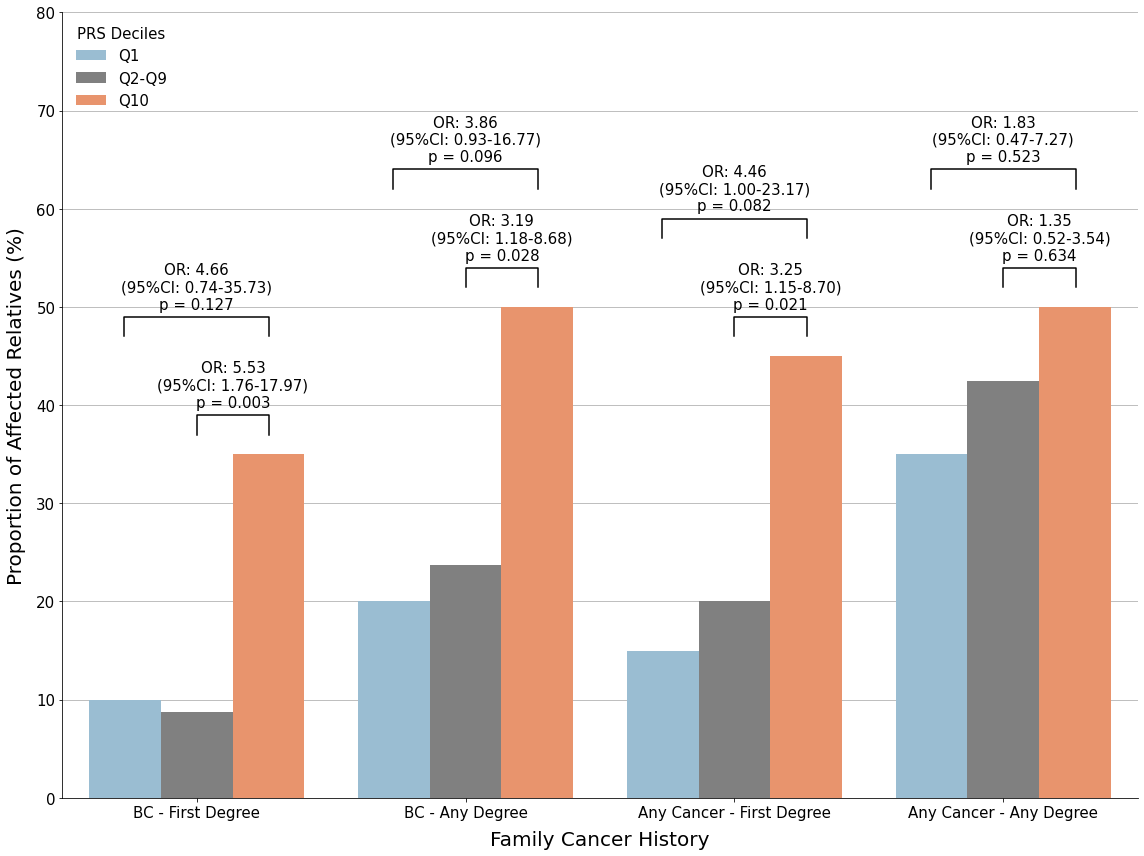

In [57]:
def add_stat_bar(ax,bar_x1,bar_x2,bar_y1,bar_y2,bar_y_top,text="ns",bar_color="black",text_offset=0.5,text_size=medium_font):
    ax.plot([bar_x1, bar_x1, bar_x2, bar_x2], [bar_y1, bar_y_top, bar_y_top, bar_y2], lw=1.5, c=bar_color)
    ax.text((bar_x1+bar_x2)*.5, bar_y_top+text_offset, text, ha='center', va='bottom', color=bar_color,size=text_size)
    return ax

def find_bar_x(string):
    lookup = {
        "BC - First Degree": 0,
        "BC - Any Degree": 1,
        "Any Cancer - First Degree":2,
        "Any Cancer - Any Degree":3
    }
    return lookup[string]

labels_to_plot = [
    "FirstDegreeBC",
    "AnyDegreeBC",
    "FamilyCancer_FirstDegree",
    "FamilyCancer_AnyDegree",
]

from palettable.colorbrewer.diverging import RdYlBu_3

palette = {
    "Q1": RdYlBu_3.mpl_colors[2],
    "Q2-Q9": "gray",
    "Q10": RdYlBu_3.mpl_colors[0]
}

fig,ax = plt.subplots(figsize=(16,12))
ax.grid(axis="y")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylim((0,80))

for idx,row in odds_ratio_pair_test_table.iterrows():
    cur_or = f"{row['OR']:.2f}"
    or_lower = f"{row['OR_95CI_lower']:.2f}"
    or_upper = f"{row['OR_95CI_upper']:.2f}"
    cur_pval = f"{row['fisher_pval']:.3f}"
    if row["group_1"] == "Q10":
        init_x = find_bar_x(row["label"])
        if row["group_2"] == "Q1":
            bar_x1 = init_x-0.27
        elif row["group_2"] == "Q2-Q9":
            bar_x1 = init_x
        bar_x2 = init_x+0.27
        
        text = f"OR: {cur_or}\n(95%CI: {or_lower}-{or_upper})\np = {cur_pval}"
        g1_y = row["group_1_case"] / (row["group_1_case"]+row["group_1_control"])
        g2_y = row["group_2_case"] / (row["group_2_case"]+row["group_2_control"])
        bar_y = max(g1_y,g2_y) * 100
        bar_y += 2
        if row["group_2"] == "Q1":
            bar_y += 10
        add_stat_bar(ax,
                     bar_x1=bar_x1,bar_x2=bar_x2,
                     bar_y1=bar_y,bar_y_top=bar_y+2,bar_y2=bar_y,
                     text = text)

            

ax.tick_params(axis='both', which='major', labelsize=medium_font)

prevalence_barplot = sns.barplot(data=odds_ratio_df_plain,x="label",y="percentage",hue="quantile_text",ax=ax,palette=palette,zorder=100)
sns.move_legend(prevalence_barplot,loc="upper left",frameon=False,title="PRS Deciles",fontsize=medium_font,title_fontsize=medium_font)

ax.set_ylabel("Proportion of Affected Relatives (%)",size=large_font,labelpad=10)
ax.set_xlabel("Family Cancer History",size=large_font,labelpad=10)

plt.tight_layout()
plt.savefig("figures/fig_7_pre_removal_prs_deciles.png",dpi=300)#,bbox_layout="tight")
plt.savefig("figures/fig_7_pre_removal_prs_deciles.eps",dpi=300)#,bbox_layout="tight")



## Panel B (Post-Removal)

In [58]:
odds_ratio_df_no_patho = make_odds_ratio_table(
    clinical_df_filtered[clinical_df_filtered["Patho_Short_Variant_Carrier"]==False],
    prs_to_use_adjusted_std,
    labels_to_plot,
    num_q=10,
    merge_middle=True
)

odds_ratio_df_no_patho = odds_ratio_df_no_patho.replace({
    "FirstDegreeBC":"BC - First Degree",
    "AnyDegreeBC": "BC - Any Degree",
    "FamilyCancer_FirstDegree" :"Any Cancer - First Degree",
    "FamilyCancer_AnyDegree": "Any Cancer - Any Degree"
})

odds_ratio_no_patho_pair_test_table = create_pair_test_df(odds_ratio_df_no_patho)
odds_ratio_no_patho_pair_test_table

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,label,group_1,group_2,group_1_case,group_1_control,group_2_case,group_2_control,OR,OR_95CI_lower,OR_95CI_upper,fisher_pval
0,BC - First Degree,Q1,Q2-Q9,0,17,9,124,0.000000,0.0000,3.6549,0.598448
1,BC - First Degree,Q1,Q10,0,17,6,11,0.000000,0.0000,0.6518,0.018404
2,BC - First Degree,Q2-Q9,Q1,9,124,0,17,inf,0.2736,inf,0.598448
3,BC - First Degree,Q2-Q9,Q10,9,124,6,11,0.136200,0.0375,0.4902,0.002328
4,BC - First Degree,Q10,Q1,6,11,0,17,inf,1.5342,inf,0.018404
5,BC - First Degree,Q10,Q2-Q9,6,11,9,124,7.342132,2.0401,26.6624,0.002328
6,BC - Any Degree,Q1,Q2-Q9,1,16,25,108,0.271631,0.0126,1.8104,0.308180
7,BC - Any Degree,Q1,Q10,1,16,9,8,0.060728,0.0024,0.5612,0.006600
8,BC - Any Degree,Q2-Q9,Q1,25,108,1,16,3.681464,0.5524,79.5770,0.308180
9,BC - Any Degree,Q2-Q9,Q10,25,108,9,8,0.208645,0.0693,0.6037,0.003739


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/utils.py:387: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles


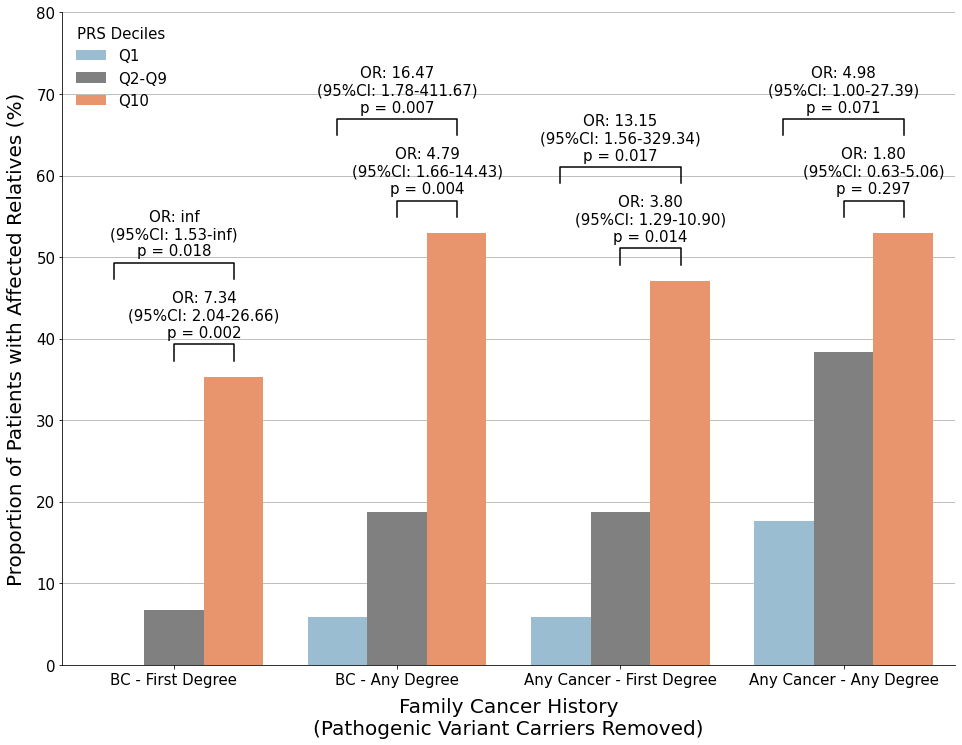

In [60]:
palette = {
    "Q1": RdYlBu_3.mpl_colors[2],
    "Q2-Q9": "gray",
    "Q10": RdYlBu_3.mpl_colors[0]
}

fig,ax = plt.subplots(figsize=(16,12))
ax.grid(axis="y")

ax.set_ylim((0,80))

for idx,row in odds_ratio_no_patho_pair_test_table.iterrows():
    cur_or = f"{row['OR']:.2f}"
    or_lower = f"{row['OR_95CI_lower']:.2f}"
    or_upper = f"{row['OR_95CI_upper']:.2f}"
    cur_pval = f"{row['fisher_pval']:.3f}"
    if row["group_1"] == "Q10":
        init_x = find_bar_x(row["label"])
        if row["group_2"] == "Q1":
            bar_x1 = init_x-0.27
        elif row["group_2"] == "Q2-Q9":
            bar_x1 = init_x
        bar_x2 = init_x+0.27
        
        text = f"OR: {cur_or}\n(95%CI: {or_lower}-{or_upper})\np = {cur_pval}"
        g1_y = row["group_1_case"] / (row["group_1_case"]+row["group_1_control"])
        g2_y = row["group_2_case"] / (row["group_2_case"]+row["group_2_control"])
        bar_y = max(g1_y,g2_y) * 100
        bar_y += 2
        if row["group_2"] == "Q1":
            bar_y += 10
        add_stat_bar(ax,
                     bar_x1=bar_x1,bar_x2=bar_x2,
                     bar_y1=bar_y,bar_y_top=bar_y+2,bar_y2=bar_y,
                     text = text)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(axis='both', which='major', labelsize=medium_font)

prevalence_barplot = sns.barplot(data=odds_ratio_df_no_patho,x="label",y="percentage",hue="quantile_text",ax=ax,palette=palette,zorder=100)
sns.move_legend(prevalence_barplot,loc="upper left",frameon=False,title="PRS Deciles",fontsize=medium_font,title_fontsize=medium_font)


ax.set_ylabel("Proportion of Patients with Affected Relatives (%)",size=large_font,labelpad=10)
ax.set_xlabel("Family Cancer History\n(Pathogenic Variant Carriers Removed)",size=large_font,labelpad=10)

plt.savefig("figures/fig_7_post_removal_prs_deciles.png",dpi=300)#,bbox_layout="tight")
plt.savefig("figures/fig_7_post_removal_prs_deciles.eps",dpi=300)#,bbox_layout="tight")




## Panel C) (Compare AUROCs before/after removal of pathogenic variant carriers)

In [61]:
labels_to_plot = [
    "FirstDegreeBC",
    "AnyDegreeBC",
    "FamilyCancer_FirstDegree",
    "FamilyCancer_AnyDegree",
]

def get_pred_auc_df(df,pred_col,labels_to_plot):
    auroc_df_rows = []

    for idx,label in enumerate(labels_to_plot):
        notna_df = df[df[label].notna()].copy()
        if truth_labels:
            truth = (notna_df[label] == truth_labels[idx]).astype(int).to_numpy()
        else:
            truth = notna_df[label].astype(int).to_numpy()
        num_case = np.sum(truth)
        num_control = len(notna_df)-num_case
        pred = notna_df[pred_col].to_numpy()
        truth = notna_df[label].astype(int).to_numpy()

        fpr, tpr, thresh = metrics.roc_curve(truth, pred)
        auc = metrics.roc_auc_score(truth, pred)
        _,auc_lower,auc_upper = calc_auc_conf(auc,num_case,num_control)
        auroc_df_rows.append([label,num_case,num_control,len(notna_df),auc,auc_lower,auc_upper])
    
    return pd.DataFrame(
        columns=["label","num_case","num_control","num_total","auc","auc_95CI_lower","auc_95CI_upper"],
        data=auroc_df_rows
    )

auc_df = get_pred_auc_df(clinical_df_filtered,prs_to_use_adjusted_std,labels_to_plot)
auc_df["Group"] = f"All Individuals\n(n={len(clinical_df_filtered)})"
auc_df_no_patho = get_pred_auc_df(clinical_df_filtered[clinical_df_filtered["Patho_Short_Variant_Carrier"]==False],prs_to_use_adjusted_std,labels_to_plot)
auc_df_no_patho["Group"] = f"Pathogenic Variant Carriers Excluded\n(n={len(clinical_df_filtered[clinical_df_filtered['Patho_Short_Variant_Carrier']==False])})"

auc_df_combined = pd.concat([auc_df,auc_df_no_patho],ignore_index=True)
auc_df_combined["auc_err_high"] = auc_df_combined["auc_95CI_upper"] - auc_df_combined["auc"]
auc_df_combined["auc_err_low"] = auc_df_combined["auc"] - auc_df_combined["auc_95CI_lower"]

name_replace_dict = {
    "FirstDegreeBC":"BC occurence in 1st degree relative",
    "AnyDegreeBC": "BC occurence in up to 2nd degree relative",
    "FamilyCancer_FirstDegree" :"Any cancer occurence in 1st degree relative",
    "FamilyCancer_AnyDegree": "Any cancer occurence in up to 2nd degree relative"
}

auc_df_combined = auc_df_combined.replace(name_replace_dict)
auc_df_combined = auc_df_combined.sort_values(by=["label","auc"]).copy()
auc_df_combined["group_plot_order"] = [2,2,0,0,3,3,1,1]
auc_df_combined = auc_df_combined.sort_values(by=["group_plot_order","label","auc"]).copy()
auc_df_combined["group_plot_order_shifted"] = [i//2 - (np.power(-1,i)*0.2) for i in range(len(auc_df_combined["group_plot_order"]))]
auc_df_combined
    


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,label,num_case,num_control,num_total,auc,auc_95CI_lower,auc_95CI_upper,Group,auc_err_high,auc_err_low,group_plot_order,group_plot_order_shifted
3,Any cancer occurence in up to 2nd degree relative,86,114,200,0.546512,0.465578,0.627445,All Individuals\n(n=200),0.080933,0.080933,0,-0.2
7,Any cancer occurence in up to 2nd degree relative,66,100,166,0.591061,0.501793,0.680329,Pathogenic Variant Carriers Excluded\n(n=166),0.089268,0.089268,0,0.2
1,BC occurence in up to 2nd degree relative,53,147,200,0.604800,0.513487,0.696114,All Individuals\n(n=200),0.091314,0.091314,1,0.8
5,BC occurence in up to 2nd degree relative,37,129,166,0.671066,0.566699,0.775434,Pathogenic Variant Carriers Excluded\n(n=166),0.104367,0.104367,1,1.2
2,Any cancer occurence in 1st degree relative,45,155,200,0.589534,0.492314,0.686754,All Individuals\n(n=200),0.097220,0.097220,2,1.8
6,Any cancer occurence in 1st degree relative,36,130,166,0.650427,0.543813,0.757042,Pathogenic Variant Carriers Excluded\n(n=166),0.106615,0.106615,2,2.2
0,BC occurence in 1st degree relative,25,175,200,0.662629,0.540168,0.785089,All Individuals\n(n=200),0.122461,0.122461,3,2.8
4,BC occurence in 1st degree relative,18,148,166,0.772523,0.641044,0.904001,Pathogenic Variant Carriers Excluded\n(n=166),0.131478,0.131478,3,3.2


### Bootstrapping


In [62]:
# ## This takes a while to run (10-20 minutes on my machine), uncomment to generate the bootstrapped df

# boot_iter = 10000
# boot_auc_dfs = []

# for i in range(boot_iter):
#     boot_df = clinical_df_filtered.sample(frac=1,replace=True,random_state=i)
#     boot_auc_df = get_pred_auc_df(boot_df,prs_to_use_adjusted_std,labels_to_plot)
#     boot_auc_df["boot_iter"] = i
#     boot_auc_df["group"] = "all_individuals"
#     boot_auc_dfs.append(boot_auc_df)
    
#     boot_df_no_patho = boot_df[boot_df["Patho_Short_Variant_Carrier"]==False]
#     boot_df_no_patho = get_pred_auc_df(boot_df_no_patho,prs_to_use_adjusted_std,labels_to_plot)
#     boot_df_no_patho["boot_iter"] = i
#     boot_df_no_patho["group"] = "no_patho_individuals"
#     boot_auc_dfs.append(boot_df_no_patho)
    
    
# booted_auc_df = pd.concat(boot_auc_dfs,ignore_index=True)


# booted_auc_df.to_csv("data/outputs/bootstrapped_auc_df.tsv",sep="\t",index=False)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [63]:
booted_auc_df = pd.read_csv("data/outputs/bootstrapped_auc_df.tsv",sep="\t")
booted_auc_df.head()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,label,num_case,num_control,num_total,auc,auc_95CI_lower,auc_95CI_upper,boot_iter,group
0,FirstDegreeBC,25,175,200,0.680457,0.558999,0.801915,0,all_individuals
1,AnyDegreeBC,48,152,200,0.535773,0.441006,0.630540,0,all_individuals
2,FamilyCancer_FirstDegree,44,156,200,0.594697,0.496691,0.692703,0,all_individuals
3,FamilyCancer_AnyDegree,78,122,200,0.513346,0.430992,0.595700,0,all_individuals
4,FirstDegreeBC,18,141,159,0.790386,0.661981,0.918791,0,no_patho_individuals


In [64]:
all_individuals_df = booted_auc_df[booted_auc_df["group"]=="all_individuals"].copy()
no_patho_individuals_df = booted_auc_df[booted_auc_df["group"]=="no_patho_individuals"].copy()

auc_diff_df = all_individuals_df[["label","boot_iter"]].copy()
auc_diffs = no_patho_individuals_df["auc"].to_numpy() - all_individuals_df["auc"].to_numpy()
auc_diff_df["auc_diff"] = auc_diffs
auc_diff_df

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,label,boot_iter,auc_diff
0,FirstDegreeBC,0,0.109929
1,AnyDegreeBC,0,0.078224
2,FamilyCancer_FirstDegree,0,0.057068
3,FamilyCancer_AnyDegree,0,0.047255
8,FirstDegreeBC,1,0.068774
...,...,...,...
79987,FamilyCancer_AnyDegree,9998,0.043725
79992,FirstDegreeBC,9999,0.064173
79993,AnyDegreeBC,9999,0.088299
79994,FamilyCancer_FirstDegree,9999,0.032234


In [65]:
pval_df_rows = []
for label in auc_diff_df["label"].unique():
    cur_df = auc_diff_df[auc_diff_df["label"]==label]
    failed = len(cur_df[cur_df["auc_diff"]<0])
    total = len(cur_df)
    # We check the number of times when removing patho resulted in LESS AUC than not removing, thats the p-value
    pval = failed/total
    pval_df_rows.append([label,failed,total,pval])
pval_df = pd.DataFrame(columns=["label","failed_trial","total_trial","pval"],data=pval_df_rows)
pval_df

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,label,failed_trial,total_trial,pval
0,FirstDegreeBC,136,10000,0.0136
1,AnyDegreeBC,145,10000,0.0145
2,FamilyCancer_FirstDegree,149,10000,0.0149
3,FamilyCancer_AnyDegree,131,10000,0.0131


In [66]:
booted_auc_df_to_plot = booted_auc_df.copy()
booted_auc_df_to_plot = booted_auc_df_to_plot.replace({
    "FirstDegreeBC": "1st-degree Relative\n(Breast Cancer)",
    "AnyDegreeBC": "Any-degree Relative\n(Breast Cancer)",
    "FamilyCancer_FirstDegree": "1st-degree Relative\n(Any Cancer)",
    "FamilyCancer_AnyDegree": "Any-degree Relative\n(Any Cancer)",
    "all_individuals": "Entire Cohort",
    "no_patho_individuals": "PV Carriers Removed"
})

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
auc_df_combined

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,label,num_case,num_control,num_total,auc,auc_95CI_lower,auc_95CI_upper,Group,auc_err_high,auc_err_low,group_plot_order,group_plot_order_shifted
3,Any cancer occurence in up to 2nd degree relative,86,114,200,0.546512,0.465578,0.627445,All Individuals\n(n=200),0.080933,0.080933,0,-0.2
7,Any cancer occurence in up to 2nd degree relative,66,100,166,0.591061,0.501793,0.680329,Pathogenic Variant Carriers Excluded\n(n=166),0.089268,0.089268,0,0.2
1,BC occurence in up to 2nd degree relative,53,147,200,0.604800,0.513487,0.696114,All Individuals\n(n=200),0.091314,0.091314,1,0.8
5,BC occurence in up to 2nd degree relative,37,129,166,0.671066,0.566699,0.775434,Pathogenic Variant Carriers Excluded\n(n=166),0.104367,0.104367,1,1.2
2,Any cancer occurence in 1st degree relative,45,155,200,0.589534,0.492314,0.686754,All Individuals\n(n=200),0.097220,0.097220,2,1.8
6,Any cancer occurence in 1st degree relative,36,130,166,0.650427,0.543813,0.757042,Pathogenic Variant Carriers Excluded\n(n=166),0.106615,0.106615,2,2.2
0,BC occurence in 1st degree relative,25,175,200,0.662629,0.540168,0.785089,All Individuals\n(n=200),0.122461,0.122461,3,2.8
4,BC occurence in 1st degree relative,18,148,166,0.772523,0.641044,0.904001,Pathogenic Variant Carriers Excluded\n(n=166),0.131478,0.131478,3,3.2


In [68]:
patho_individual_og_df = auc_df_combined[auc_df_combined["Group"]=="Pathogenic Variant Carriers Excluded\n(n=166)"].copy()
all_individual_og_df = auc_df_combined[auc_df_combined["Group"]=="All Individuals\n(n=200)"].copy()

auc_diff_og_df = all_individual_og_df[["label"]].copy()
all_indi_temp = all_individual_og_df[["num_case","num_control","num_total","auc"]].copy()
all_indi_temp.columns = [f"{col}_entire_cohort" for col in all_indi_temp.columns]
auc_diff_og_df = pd.concat([auc_diff_og_df,all_indi_temp],axis=1,ignore_index=False).reset_index(drop=True)


patho_temp = patho_individual_og_df[["num_case","num_control","num_total","auc"]].copy()
patho_temp_columns = [f"{col}_non_PV_carriers_only" for col in patho_temp.columns]
patho_temp.columns = patho_temp_columns

auc_diff_og_df[patho_temp_columns] = patho_temp[patho_temp_columns].to_numpy()

auc_diff_og_df["auc_diff"] = auc_diff_og_df["auc_non_PV_carriers_only"].to_numpy() - auc_diff_og_df["auc_entire_cohort"].to_numpy()
auc_diff_og_df["auc_diff_relative"] = auc_diff_og_df["auc_diff"] / auc_diff_og_df["auc_entire_cohort"]
auc_diff_og_df


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,label,num_case_entire_cohort,num_control_entire_cohort,num_total_entire_cohort,auc_entire_cohort,num_case_non_PV_carriers_only,num_control_non_PV_carriers_only,num_total_non_PV_carriers_only,auc_non_PV_carriers_only,auc_diff,auc_diff_relative
0,Any cancer occurence in up to 2nd degree relative,86,114,200,0.546512,66.0,100.0,166.0,0.591061,0.044549,0.081515
1,BC occurence in up to 2nd degree relative,53,147,200,0.604800,37.0,129.0,166.0,0.671066,0.066266,0.109567
2,Any cancer occurence in 1st degree relative,45,155,200,0.589534,36.0,130.0,166.0,0.650427,0.060893,0.103291
3,BC occurence in 1st degree relative,25,175,200,0.662629,18.0,148.0,166.0,0.772523,0.109894,0.165845


In [69]:
auc_diff_og_df.to_csv("data/outputs/prs_auc_diff_when_PV_removed.tsv",index=False,sep="\t")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Plotting

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/utils.py:387: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles


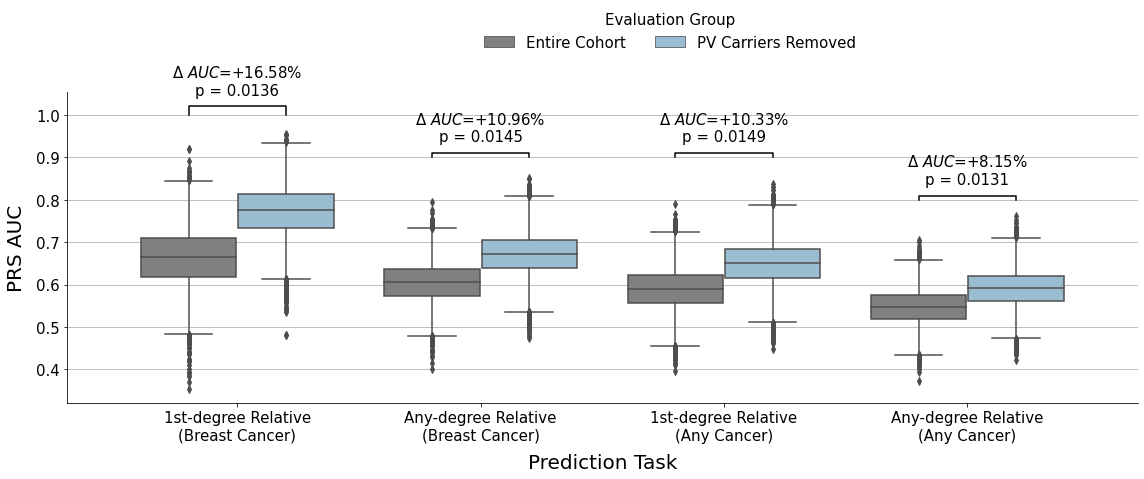

In [70]:
fig,ax = plt.subplots(figsize=(16,7))

hue_colors = {
    "Entire Cohort":"gray",
    "PV Carriers Removed":RdYlBu_3.mpl_colors[2]
}

sns.boxplot(data=booted_auc_df_to_plot,x="label",y="auc",hue="group",ax=ax,palette=hue_colors)

bootstrap_pval_first_bc = pval_df[pval_df["label"]=="FirstDegreeBC"]["pval"].item()
bootstrap_pval_any_bc = pval_df[pval_df["label"]=="AnyDegreeBC"]["pval"].item()
bootstrap_pval_first_cancer = pval_df[pval_df["label"]=="FamilyCancer_FirstDegree"]["pval"].item()
bootstrap_pval_any_cancer = pval_df[pval_df["label"]=="FamilyCancer_AnyDegree"]["pval"].item()

auc_diff_first_bc = auc_diff_og_df[auc_diff_og_df["label"]=="BC occurence in 1st degree relative"]["auc_diff_relative"].item()*100
auc_diff_any_bc = auc_diff_og_df[auc_diff_og_df["label"]=="BC occurence in up to 2nd degree relative"]["auc_diff_relative"].item()*100
auc_diff_first_cancer = auc_diff_og_df[auc_diff_og_df["label"]=="Any cancer occurence in 1st degree relative"]["auc_diff_relative"].item()*100
auc_diff_any_cancer = auc_diff_og_df[auc_diff_og_df["label"]=="Any cancer occurence in up to 2nd degree relative"]["auc_diff_relative"].item()*100

first_bc_text = r"${\Delta}\ AUC$" + f"={auc_diff_first_bc:+.2f}%"+ f"\np = {bootstrap_pval_first_bc}"
any_bc_text = r"${\Delta}\ AUC$" + f"={auc_diff_any_bc:+.2f}%"+ f"\np = {bootstrap_pval_any_bc}"
first_cancer_text = r"${\Delta}\ AUC$" + f"={auc_diff_first_cancer:+.2f}%"+ f"\np = {bootstrap_pval_first_cancer}"
any_cancer_text = r"${\Delta}\ AUC$" + f"={auc_diff_any_cancer:+.2f}%"+ f"\np = {bootstrap_pval_any_cancer}"

add_stat_bar(ax,bar_x1=-0.2,bar_x2=0.2,bar_y1=1,bar_y2=1,bar_y_top=1.02,text = first_bc_text,text_offset=0.02)
add_stat_bar(ax,bar_x1=1-0.2,bar_x2=1+0.2,bar_y1=0.9,bar_y2=0.9,bar_y_top=0.91,text = any_bc_text,text_offset=0.02)
add_stat_bar(ax,bar_x1=2-0.2,bar_x2=2+0.2,bar_y1=0.9,bar_y2=0.9,bar_y_top=0.91,text = first_cancer_text,text_offset=0.02)
add_stat_bar(ax,bar_x1=3-0.2,bar_x2=3+0.2,bar_y1=0.8,bar_y2=0.8,bar_y_top=0.81,text = any_cancer_text,text_offset=0.02)

ax.set_axisbelow(True)
ax.grid(axis="y")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(axis='both', which='major', labelsize=medium_font)
ax.set_ylabel("PRS AUC",size=large_font,labelpad=10)
ax.set_xlabel("Prediction Task",size=large_font,labelpad=10)

sns.move_legend(
    ax,loc="upper right",frameon=False,fontsize=medium_font,title_fontsize=medium_font,
    title="Evaluation Group",bbox_to_anchor=(0.75,1.3),ncol=2
)

plt.subplots_adjust(bottom=0.15)

plt.tight_layout()
plt.savefig("figures/fig_7_pv_removal_auc_comparison.png",dpi=300)#,bbox_layout="tight")
plt.savefig("figures/fig_7_pv_removal_auc_comparison.eps",dpi=300)#,bbox_layout="tight")




# Supplementary Materials

## S1: Clinical Data Table 

In [71]:
pv_table =  pd.read_csv("data/supplementary_tables/S5_PV_Carrier_Table.tsv",sep="\t")
pv_table_no_dup = pv_table.drop_duplicates(subset=["Carrier"])
clinical_df_temp = clinical_df.merge(pv_table_no_dup,left_on="ID",right_on="Carrier",how="left")
clinical_df_temp["Histology"] = clinical_df_temp["Histology"].apply(lambda x: x.split("-")[1] if x == x else x)
clinical_df_temp["Gene"] = clinical_df_temp["Gene"].fillna("None")
clinical_df_temp.loc[
    clinical_df_temp["Carrier"].isin(pv_table[pv_table["Carrier"].duplicated()]["Carrier"]),"Gene"
] = "Multiple"
clinical_df_temp[["ER+","PR+","HER2+"]] = clinical_df_temp[["ER+","PR+","HER2+"]].replace({
    True: "Positive",
    False: "Negative"
})
clinical_df_temp

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ID,Age,Histology,CancerGrade,CancerStage_T,CancerStage_N,CancerStage_M,ER+,PR+,HER2+,...,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,Carrier,Gene,Pathogenic Variant Type
0,BC_P_001,47.0,Invasive lobular carcinoma,2-Grade 2,2-T2,0-No,0-M0,Positive,Positive,Negative,...,0.014054,0.005960,-0.016127,0.006660,0.018212,-0.004800,-0.007986,BC_P_001,BRCA2,frameshift_variant
1,BC_P_002,47.0,Invasive lobular carcinoma,2-Grade 2,3-T3,1-N1,0-M0,Positive,Negative,Negative,...,0.025561,0.003875,-0.007231,0.009379,0.012910,0.008274,0.003415,NaN,None,NaN
2,BC_P_003,44.0,Invasive ductal carcinoma,3-Grade 3,3-T3,0-No,0-M0,Negative,Negative,Negative,...,0.008720,0.003740,-0.015715,0.008654,0.008089,0.000078,0.006885,BC_P_003,BRCA2,frameshift_variant
3,BC_P_004,57.0,Lobular carcinoma in situ,2-Grade 2,1-T1c,0-No,0-M0,Positive,Positive,Negative,...,0.005976,0.005031,-0.009841,0.005231,0.007291,-0.001679,-0.001122,NaN,None,NaN
4,BC_P_005,47.0,Invasive ductal carcinoma,2-Grade 2,2-T2,0-No,0-M0,Negative,Negative,Positive,...,0.007751,0.003208,0.000312,0.005803,0.004934,0.000394,0.004869,BC_P_005,ATM,splice_acceptor_variant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,BC_P_236,64.0,Lobular carcinoma in situ,2-Grade 2,1-T1c,0-No,0-M0,Positive,Positive,NaN,...,0.003463,0.005411,-0.016236,0.007241,0.004703,-0.003644,-0.000023,NaN,None,NaN
216,BC_P_237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.017252,0.012967,-0.017050,0.002684,0.006184,-0.004611,-0.003562,NaN,None,NaN
217,BC_P_238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.010996,0.003402,-0.005889,0.011400,0.002479,-0.008722,-0.001969,NaN,None,NaN
218,BC_P_239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.023490,0.023324,-0.032819,0.015150,0.003118,-0.011115,-0.001439,NaN,None,NaN


In [72]:
table_one_columns = [
    "Age","ER+","PR+","HER2+","Histology","Gene",
]

table_one_labels={
    prs_to_use_adjusted_std: 'PRS',
    "Patho_Short_Variant_Carrier": "Pathogenic Variant Carrier",
    "FirstDegreeBC": "Has 1st Degree Relative with Breast Cancer",
    "Gene": "Gene with Pathogenic Variant"
    
}
table_one_categorical = ["ER+","PR+","HER2+","Histology","Gene"]
mytable = TableOne(
    clinical_df_temp,
    columns=table_one_columns,
    categorical=table_one_categorical,
    groupby=["FirstDegreeBC"],
    rename=table_one_labels,
    pval=True
)

mytable

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Grouped by Has 1st Degree Relative with Breast Cancer                                              
                                                                                                                                   Missing      Overall        False        True P-Value
n                                                                                                                                                   220          177          27        
Age, mean (SD)                                                                                                                          16  47.7 (10.1)  47.7 (10.2)  47.5 (9.6)   0.912
ER+, n (%)                          Negative                                                                                            72    30 (20.3)    27 (20.8)    3 (17.6)   1.000
                                    Positive                                                                                                 118 (79.7)   103 (79.2)   14 (82.4)        
PR+, n (%)                          Negative                                                                                            72    40 (27.0)    36 (27.7)    4 (23.5)   1.000
                                    Positive                                                                                                 108 (73.0)    94 (72.3)   13 (76.5)        
HER2+, n (%)                        Negative                                                                                            80   106 (75.7)    93 (76.2)   13 (76.5)   1.000
                                    Positive                                                                                                  34 (24.3)    29 (23.8)    4 (23.5)        
Histology, n (%)                     Other                                                                                              16     11 (5.4)      9 (5.1)     2 (7.4)   0.595
                                    Ductal carcinoma in situ                                                                                  22 (10.8)    18 (10.2)    4 (14.8)        
                                    Inflammatory breast cancer                                                                                  2 (1.0)      2 (1.1)                    
                                    Invasive ductal carcinoma                                                                                137 (67.2)   122 (68.9)   15 (55.6)        
                                    Invasive lobular carcinoma                                                                                21 (10.3)     16 (9.0)    5 (18.5)        
                                    Lobular carcinoma in situ                                                                                   4 (2.0)      4 (2.3)                    
                                    Medullary carcinoma Mucinous (colloid) carcinoma                                                            2 (1.0)      2 (1.1)                    
                                    Papillary carcinoma                                                                                         2 (1.0)      2 (1.1)                    
                                    Phyllodes tumors                                                                                            1 (0.5)      1 (0.6)                    
                                    Tubular carcinoma                                                                                           2 (1.0)      1 (0.6)     1 (3.7)        
Gene with Pathogenic Variant, n (%) ATM                                                                                                  0      4 (1.8)      3 (1.7)     1 (3.7)   0.452
                                    BRCA1                                                                                                       4 (1.8)      3 (1.7)     1 (3.7)        
               

In [73]:
mytable.to_csv("data/supplementary_tables/S1_clinical_characteristics_by_family_history.tsv",sep="\t")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## S2: Imputation Performance by INFO Table (See PlotExome Notebook)

## S3: Imputation Performance by MAF Table  (See PlotExome Notebook)

## S4: PRS Performance Table

In [74]:
prs_web_fam_df_merged_supp_table = prs_web_fam_df_merged.copy()
column_names_pretty_order = [
    "prs_name","# SNPS","Method","DB",
    "prs_first_fam_auroc_prs_only","prs_resid_first_fam_auroc",
    "prs_any_fam_auroc_prs_only","prs_resid_any_fam_auroc",
    "prs_adjusted_delta_first_fam","prs_adjusted_delta_any_fam"
]

prs_web_fam_df_merged_supp_table = prs_web_fam_df_merged_supp_table[column_names_pretty_order].copy()

column_names_pretty = {
    "prs_name": "PRS ID",
    "# SNPS": "Number of SNPs in PRS",
    "Method": "PRS Derivation Method",
    "DB": "AUC_population Validation Database",
    "prs_first_fam_auroc_prs_only": 'PRS_raw AUC_fam',
    "prs_resid_first_fam_auroc": 'PRS_adjusted AUC_fam',
    "prs_any_fam_auroc_prs_only": "PRS_raw AUC_fam-any",
    "prs_resid_any_fam_auroc": "PRS_adjusted AUC_fam-any",
    "prs_adjusted_delta_first_fam":"Change in AUC_fam after adjusting for population",
    "prs_adjusted_delta_any_fam": "Change in AUC_fam-any after adjusting for population"
}


prs_web_fam_df_merged_supp_table = prs_web_fam_df_merged_supp_table.rename(columns=column_names_pretty)
prs_web_fam_df_merged_supp_table

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,PRS ID,Number of SNPs in PRS,PRS Derivation Method,AUC_population Validation Database,PRS_raw AUC_fam,PRS_adjusted AUC_fam,PRS_raw AUC_fam-any,PRS_adjusted AUC_fam-any,Change in AUC_fam after adjusting for population,Change in AUC_fam-any after adjusting for population
0,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LA...,NaN,NaN,MGI,0.649371,0.662629,0.596072,0.604800,1.325714e-02,0.008728
1,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LA...,NaN,NaN,MGI,0.649371,0.662629,0.596072,0.604800,1.325714e-02,0.008728
2,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LA...,118388.0,Lassosum,MGI,0.649371,0.662629,0.596072,0.604800,1.325714e-02,0.008728
3,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_LA...,286144.0,Lassosum,UKB,0.655771,0.661943,0.587088,0.586831,6.171429e-03,-0.000257
4,PRSWEB_PHECODE174.1_UKBB-SAIGE-HRC-X174.1_LASS...,6977.0,Lassosum,MGI,0.666171,0.656000,0.581954,0.579772,-1.017143e-02,-0.002182
5,PRSWEB_PHECODE174.1_iCOGS-Overall-BRCA_PRS-CS_...,1116546.0,PRS-CS,UKB,0.625029,0.641829,0.551405,0.563214,1.680000e-02,0.011808
6,PRSWEB_PHECODE174.1_GWAS-Catalog-r2019-05-03-X...,79.0,P&T,UKB,0.573486,0.572571,0.556283,0.553074,-9.142857e-04,-0.003209
7,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_PT...,1682.0,P&T,UKB,0.566857,0.579657,0.551149,0.551277,1.280000e-02,0.000128
8,PRSWEB_PHECODE174.1_GWAS-Catalog-r2019-05-03-X...,105.0,GWAS Catalog ($p<5\times10^{-5}$),UKB,0.558400,0.549943,0.562315,0.551020,-8.457143e-03,-0.011295
9,PRSWEB_PHECODE174.1_Onco-iCOGS-Overall-BRCA_PT...,3038.0,P&T,MGI,0.593029,0.601829,0.551983,0.550635,8.800000e-03,-0.001348


In [75]:
prs_web_fam_df_merged_supp_table.to_csv(
    "data/supplementary_tables/S4_prs_performance.tsv",
    sep="\t",index=False
)




/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## S5: List of PV carriers and the type of pathogenic variants in the caner-predisposition genes

In [80]:
pv_carrier_table = pd.read_csv("data/supplementary_tables/S5_Pathogenic_Variants_Carriers.tsv",sep="\t")
pv_ct = pd.crosstab(pv_carrier_table["Gene"],pv_carrier_table["Pathogenic Variant Type"])
pv_ct


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Pathogenic Variant Type,frameshift_variant,inframe_deletion,missense_variant,splice_acceptor_variant,start_lost,stop_gained,"stop_gained,splice_region_variant"
Gene,,,,,,,
ATM,3,0,0,0,0,0,0
BRCA1,3,0,0,0,0,2,0
BRCA2,12,0,0,0,0,1,0
FAH,0,0,0,0,0,0,1
FANCC,0,0,0,0,0,1,0
FANCD2,0,1,0,0,0,0,0
FANCI,0,0,0,1,0,0,0
MPL,0,0,3,0,0,0,0
NF1,0,0,0,0,1,0,0


### Suppplemental Figure 2

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/utils.py:387: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


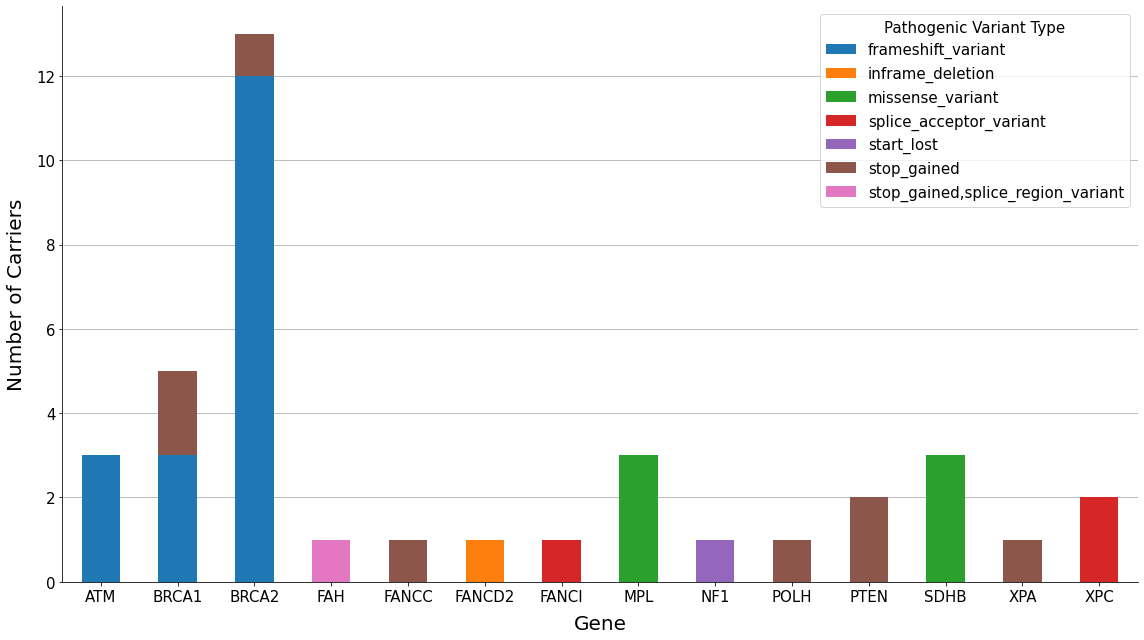

In [81]:
fig,ax = plt.subplots(figsize=(16,9))
pv_ct.plot.bar(stacked=True,ax=ax,rot=0)

ax.set_axisbelow(True)
ax.grid(axis="y")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(axis='both', which='major', labelsize=medium_font)

sns.move_legend(
    ax,
    loc="upper right",
    #frameon=False,
    title="Pathogenic Variant Type",
    fontsize=medium_font,
    title_fontsize=medium_font
)

ax.set_xlabel("Gene",size=large_font,labelpad=10)
ax.set_ylabel("Number of Carriers",size=large_font,labelpad=10)
plt.tight_layout()
plt.savefig("supplementary_figures/PV_carriers.png",dpi=300)#,bbox_layout="tight")
plt.savefig("supplementary_figures/PV_carriers.eps",dpi=300)#,bbox_layout="tight")

## S6: PRS Performance before and after removing PV carriers

In [78]:
pval_df["label"] = pval_df["label"].replace({
    "FirstDegreeBC":"BC occurence in 1st degree relative",
    "AnyDegreeBC": "Any cancer occurence in 1st degree relative",
    "FamilyCancer_FirstDegree":"Any cancer occurence in 1st degree relative",
    "FamilyCancer_AnyDegree": "Any cancer occurence in up to 2nd degree relative"
})

auc_diff_og_df_merged = auc_diff_og_df.merge(pval_df,on="label")
auc_diff_og_df_merged

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,label,num_case_entire_cohort,num_control_entire_cohort,num_total_entire_cohort,auc_entire_cohort,num_case_non_PV_carriers_only,num_control_non_PV_carriers_only,num_total_non_PV_carriers_only,auc_non_PV_carriers_only,auc_diff,auc_diff_relative,failed_trial,total_trial,pval
0,Any cancer occurence in up to 2nd degree relative,86,114,200,0.546512,66.0,100.0,166.0,0.591061,0.044549,0.081515,131,10000,0.0131
1,Any cancer occurence in 1st degree relative,45,155,200,0.589534,36.0,130.0,166.0,0.650427,0.060893,0.103291,145,10000,0.0145
2,Any cancer occurence in 1st degree relative,45,155,200,0.589534,36.0,130.0,166.0,0.650427,0.060893,0.103291,149,10000,0.0149
3,BC occurence in 1st degree relative,25,175,200,0.662629,18.0,148.0,166.0,0.772523,0.109894,0.165845,136,10000,0.0136


In [79]:
auc_diff_og_df_merged.to_csv(
    "data/supplementary_tables/S6_effects_of_removing_PV_carriers.tsv",
    sep="\t",index=False
)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
